In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim

In [4]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [5]:
# 各CSVファイルの読み込み
csv_files1 = ['xy(1) copy.csv', 'xy(2) copy.csv', 'xy(3) copy.csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['xy1 copy.csv', 'xy2 copy.csv', 'xy3 copy.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [6]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [7]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [8]:
# 36通りの組み合わせを生成
permutations = list(itertools.product(itertools.permutations([0, 1, 2]), repeat=2))

# 最適化のためのobjective関数
def objective(trial, perm1, perm2):
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(trial.suggest_float('k5', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k6 = torch.tensor(trial.suggest_float('k6', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm1[i]] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm2[i]] for i in range(3)]

    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 全体で最小のLossを保持する変数
global_best_loss = float('inf')
global_best_params = None
global_best_combination = None

# 36通りの組み合わせごとにエポック計算を行うためのループ
for perm1, perm2 in permutations:
    print(f"Evaluating combination: perm1={perm1}, perm2={perm2}")

    # 最適化のための変数初期化
    best_epoch0_loss = float('inf')
    best_params = None

    for _ in range(5):
        # Optunaで最適化
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, perm1, perm2), n_trials=100)

        # epoch0のLossが最小のパラメータを保持
        if study.best_value < best_epoch0_loss:
            best_epoch0_loss = study.best_value
            best_params = study.best_params

    # エポック計算 (各組み合わせごとに計算)
    if best_params is not None:
        print(f"Starting training for combination: perm1={perm1}, perm2={perm2}")
        
        k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
        k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
        k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
        k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
        k5 = torch.nn.Parameter(torch.tensor(best_params['k5']))
        k6 = torch.nn.Parameter(torch.tensor(best_params['k6']))
        t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
        p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
        t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
        p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

        optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-1)
        prev_loss = float('inf')

        # エポックごとのトレーニング
        best_params_during_epoch = None  # エポックごとの最良パラメータ
        best_epoch_loss = float('inf')  # 最良のロスを記録

        # エポックごとのトレーニング
        for epoch in range(300000):
            optimizer.zero_grad()

            outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

            y_p1, y_p2, y_p3 = [outputs[i]['shift1'][perm1[i]] for i in range(3)]
            y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][perm2[i]] for i in range(3)]

            loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

            if epoch == 0:
                epoch0_loss = loss.item()
                if epoch0_loss >= 35:
                    print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                    break
            
            # 最良のロスを持つ場合はパラメータを保存
            if loss.item() < best_epoch_loss:
                best_epoch_loss = loss.item()
                best_params_during_epoch = {
                    'k1': k1.item(),
                    'k2': k2.item(),
                    'k3': k3.item(),
                    'k4': k4.item(),
                    'k5': k5.item(),
                    'k6': k6.item(),
                    't1': t1.item(),
                    'p1': p1.item(),
                    't2': t2.item(),
                    'p2': p2.item()
                }

            if loss.item() > prev_loss:
                print(f"Loss increased at epoch {epoch}. Stopping training.")
                break

            prev_loss = loss.item()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                for param in [k1, k2, k3, k4, k5, k6]:
                    param.data = torch.clamp(param.data, -10.0, 10.0)
                for param in [t1, p1, t2, p2]:
                    param.data = torch.clamp(param.data, 0.0, 90.0)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
                # パラメータを表示する
                print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')

        # 最良のパラメータを表示
        if best_params_during_epoch is not None:
            print(f"Best params during epoch training: {best_params_during_epoch}")
            # 最良のパラメータをTensorに変換して使用
            k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
        else:
            print("No improvement in loss during epoch training.")

        # 現在の組み合わせの最小Lossをグローバルな最小Lossと比較
        if prev_loss < global_best_loss:
            global_best_loss = prev_loss
            global_best_params = best_params_during_epoch
            global_best_combination = (perm1, perm2)

        print(f"Finished training for combination: perm1={perm1}, perm2={perm2}")

# 全体で最も良い組み合わせとパラメータを出力
print(f"Global best Loss: {global_best_loss}")
print(f"Global best params: {global_best_params}")
print(f"Global best combination: {global_best_combination}")

[I 2024-09-27 19:05:48,080] A new study created in memory with name: no-name-2f08f0f0-d787-420b-8ed8-0ac65973ef74
[I 2024-09-27 19:05:48,187] Trial 0 finished with value: 326.3469543457031 and parameters: {'k1': -9.628619125791772, 'k2': 9.03395093032184, 'k3': -3.8197935945974137, 'k4': 6.036934401732218, 'k5': -5.288657881547028, 'k6': -9.162538792598049, 't1': 43.92167068458539, 'p1': 86.99304692745673, 't2': 45.03782554977393, 'p2': 81.8105885853392}. Best is trial 0 with value: 326.3469543457031.
[I 2024-09-27 19:05:48,208] Trial 1 finished with value: 148.25054931640625 and parameters: {'k1': -6.303271846110499, 'k2': -5.385218831855536, 'k3': 6.042978788459244, 'k4': 5.17093109096367, 'k5': 1.1381424970772365, 'k6': -1.3756183503916386, 't1': 9.579752819904419, 'p1': 48.88152587464063, 't2': 62.093272623561155, 'p2': 73.22300447161093}. Best is trial 1 with value: 148.25054931640625.
[I 2024-09-27 19:05:48,229] Trial 2 finished with value: 586.1637573242188 and parameters: {'k1'

Evaluating combination: perm1=(0, 1, 2), perm2=(0, 1, 2)


[I 2024-09-27 19:05:48,292] Trial 5 finished with value: 299.8175964355469 and parameters: {'k1': -9.177674264628594, 'k2': 3.9600001479398355, 'k3': -7.2192335911743495, 'k4': 5.77328329728795, 'k5': 1.0691699673007111, 'k6': -5.975054436956835, 't1': 4.089373952532899, 'p1': 39.38110763513679, 't2': 84.50604055147048, 'p2': 78.23131538261752}. Best is trial 1 with value: 148.25054931640625.
[I 2024-09-27 19:05:48,313] Trial 6 finished with value: 203.0889892578125 and parameters: {'k1': 4.496059638595039, 'k2': 3.0414698239782716, 'k3': -4.147761384727227, 'k4': -1.5508098921426914, 'k5': 0.4564416270424161, 'k6': -9.572516165379206, 't1': 20.252703157927275, 'p1': 24.489933439512107, 't2': 66.5837765566428, 'p2': 50.824435905615935}. Best is trial 1 with value: 148.25054931640625.
[I 2024-09-27 19:05:48,334] Trial 7 finished with value: 228.11196899414062 and parameters: {'k1': -1.6312473313730713, 'k2': 3.00890476599756, 'k3': -4.414079160041791, 'k4': -2.361027845231485, 'k5': -2.

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 29.360637664794922
Parameters: k1=-8.057042121887207, k2=1.3535250425338745, k3=0.5103592872619629, k4=7.687478542327881, k5=-3.5707318782806396, k6=1.591456413269043, t1=16.49625015258789, p1=73.20289611816406, t2=79.56012725830078, p2=3.0795111656188965
Epoch 100, Loss: 1.7970350980758667
Parameters: k1=-8.3961181640625, k2=1.0095030069351196, k3=0.1766594797372818, k4=8.916071891784668, k5=0.3884628117084503, k6=-0.6005284786224365, t1=8.599087715148926, p1=64.20451354980469, t2=87.81932830810547, p2=6.86092472076416
Epoch 200, Loss: 0.27943676710128784
Parameters: k1=-8.372576713562012, k2=0.9604504108428955, k3=0.04430630803108215, k4=8.937148094177246, k5=-0.4228268265724182, k6=-0.9716142416000366, t1=3.812636375427246, p1=57.86239242553711, t2=89.31768798828125, p2=6.808113098144531
Epoch 300, Loss: 0.03866122290492058
Parameters: k1=-8.413653373718262, k2=0.9926708936691284, k3=0.013180769979953

[I 2024-09-27 19:06:43,237] A new study created in memory with name: no-name-0a15b60c-8ff5-414b-b627-42600c0e81a7
[I 2024-09-27 19:06:43,321] Trial 0 finished with value: 494.5064697265625 and parameters: {'k1': -6.835554989666948, 'k2': -1.1341537733067941, 'k3': -6.21485060092872, 'k4': 6.070803068054694, 'k5': -8.849265367717031, 'k6': -2.4938009575991993, 't1': 54.65314136668734, 'p1': 47.440050497866494, 't2': 4.365801256062218, 'p2': 67.47539000251538}. Best is trial 0 with value: 494.5064697265625.
[I 2024-09-27 19:06:43,342] Trial 1 finished with value: 264.7088317871094 and parameters: {'k1': -7.16047392820826, 'k2': -6.68942111996945, 'k3': -1.147794852756709, 'k4': 5.297382971564154, 'k5': 1.29667225597432, 'k6': 7.569443461406475, 't1': 61.468188582857984, 'p1': 33.22344564947103, 't2': 37.43996191642532, 'p2': 62.59269399342434}. Best is trial 1 with value: 264.7088317871094.
[I 2024-09-27 19:06:43,364] Trial 2 finished with value: 296.7876281738281 and parameters: {'k1': 

Loss increased at epoch 923. Stopping training.
Best params during epoch training: {'k1': -8.450897216796875, 'k2': 1.0248973369598389, 'k3': 3.886084414261859e-07, 'k4': 8.774812698364258, 'k5': -0.9856979846954346, 'k6': -1.0780521631240845, 't1': 5.676192813552916e-05, 'p1': 56.08610153198242, 't2': 89.99998474121094, 'p2': 6.4093732833862305}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 1, 2), perm2=(0, 2, 1)


[I 2024-09-27 19:06:43,454] Trial 6 finished with value: 461.3109130859375 and parameters: {'k1': 1.9804024904330007, 'k2': 4.1225513843573385, 'k3': -8.427462640600329, 'k4': 4.880130207207081, 'k5': -8.995870070077668, 'k6': -8.962086829541317, 't1': 19.144685821811137, 'p1': 2.8282999679328347, 't2': 65.67409744152162, 'p2': 3.8939400264400525}. Best is trial 3 with value: 163.7511444091797.
[I 2024-09-27 19:06:43,479] Trial 7 finished with value: 491.2794189453125 and parameters: {'k1': -1.408297113608354, 'k2': 6.032689606318463, 'k3': 3.8982319919452557, 'k4': 0.4692437832836376, 'k5': -7.902089670616855, 'k6': -6.1454229598961785, 't1': 29.408154918480136, 'p1': 47.01645351034824, 't2': 68.86879680779852, 'p2': 67.35977318925583}. Best is trial 3 with value: 163.7511444091797.
[I 2024-09-27 19:06:43,500] Trial 8 finished with value: 249.06158447265625 and parameters: {'k1': 7.956288042853231, 'k2': -8.657887525128452, 'k3': 4.191692384026954, 'k4': 3.405821770482964, 'k5': -1.29

Starting training for combination: perm1=(0, 1, 2), perm2=(0, 2, 1)
Epoch 0, Loss: 16.964075088500977
Parameters: k1=-1.3198165893554688, k2=-7.6947855949401855, k3=0.45747026801109314, k4=-2.0032150745391846, k5=9.392367362976074, k6=-1.416998028755188, t1=4.912727355957031, p1=29.0965633392334, t2=87.62296295166016, p2=75.73702239990234
Epoch 100, Loss: 0.006508372724056244
Parameters: k1=0.5247501134872437, k2=-7.947779178619385, k3=-0.0005357619374990463, k4=-2.193822145462036, k5=8.594222068786621, k6=-2.3942055702209473, t1=0.24709171056747437, p1=32.50109100341797, t2=90.0, p2=75.43006896972656


[I 2024-09-27 19:07:10,859] A new study created in memory with name: no-name-625b4d61-0f38-424a-a33c-e29bdea63dad
[I 2024-09-27 19:07:10,884] Trial 0 finished with value: 354.91558837890625 and parameters: {'k1': -6.087696296711789, 'k2': -9.841019810775883, 'k3': 4.308864062232775, 'k4': 9.243975505067748, 'k5': -3.6696597984379276, 'k6': -2.103991482614182, 't1': 14.921673620403286, 'p1': 87.60231030888104, 't2': 61.78755290876952, 'p2': 23.924223654756002}. Best is trial 0 with value: 354.91558837890625.
[I 2024-09-27 19:07:10,906] Trial 1 finished with value: 476.56610107421875 and parameters: {'k1': -0.38816827841864665, 'k2': 7.58214452046715, 'k3': -1.431759380280532, 'k4': -0.09773239252633736, 'k5': -9.055368671019279, 'k6': -9.242982975772208, 't1': 69.38516843661093, 'p1': 20.112685584318, 't2': 36.43850726525937, 'p2': 66.00638680263866}. Best is trial 0 with value: 354.91558837890625.
[I 2024-09-27 19:07:10,930] Trial 2 finished with value: 655.5507202148438 and parameters

Loss increased at epoch 176. Stopping training.
Best params during epoch training: {'k1': 0.5292191505432129, 'k2': -7.955264091491699, 'k3': 1.0805446436279453e-05, 'k4': -2.2244842052459717, 'k5': 8.545361518859863, 'k6': -2.3692092895507812, 't1': 0.0, 'p1': 32.52838134765625, 't2': 90.0, 'p2': 75.40896606445312}
Finished training for combination: perm1=(0, 1, 2), perm2=(0, 2, 1)
Evaluating combination: perm1=(0, 1, 2), perm2=(1, 0, 2)


[I 2024-09-27 19:07:11,065] Trial 8 finished with value: 399.74517822265625 and parameters: {'k1': 4.054586217178553, 'k2': -9.321095441924852, 'k3': -6.413639577258494, 'k4': 2.4063625633880985, 'k5': -5.81983149569032, 'k6': 7.927876717629193, 't1': 88.65764151911755, 'p1': 34.437550974343615, 't2': 8.135278667517769, 'p2': 32.55028577867647}. Best is trial 3 with value: 149.85186767578125.
[I 2024-09-27 19:07:11,088] Trial 9 finished with value: 244.32022094726562 and parameters: {'k1': 5.440803604841484, 'k2': -8.912698695425977, 'k3': -8.949952860463359, 'k4': -1.2971145588659105, 'k5': 5.92202688120619, 'k6': 3.3968464849756437, 't1': 31.680121074296608, 'p1': 4.512718414722894, 't2': 69.36969953693576, 'p2': 67.2456771423032}. Best is trial 3 with value: 149.85186767578125.
[I 2024-09-27 19:07:11,123] Trial 10 finished with value: 414.41632080078125 and parameters: {'k1': 9.474305062678205, 'k2': -3.3771806927066206, 'k3': -3.9322050906992905, 'k4': 8.588891887416047, 'k5': 8.28

Starting training for combination: perm1=(0, 1, 2), perm2=(1, 0, 2)
Epoch 0 Loss is 36.04998016357422, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(0, 1, 2), perm2=(1, 2, 0)


[I 2024-09-27 19:07:31,874] Trial 5 finished with value: 337.1017150878906 and parameters: {'k1': -9.603022050854172, 'k2': 6.413148356895256, 'k3': 6.1429754153407075, 'k4': 5.702312049035703, 'k5': 3.4650153386957925, 'k6': 7.425354754719308, 't1': 6.768878842073809, 'p1': 7.089211115798352, 't2': 49.5842671746449, 'p2': 87.31794082687877}. Best is trial 4 with value: 287.4864501953125.
[I 2024-09-27 19:07:31,903] Trial 6 finished with value: 658.4802856445312 and parameters: {'k1': 5.442281049701618, 'k2': 9.364182345644686, 'k3': 4.78214056421467, 'k4': -5.645648309450275, 'k5': -6.425682118216674, 'k6': -9.832848389139707, 't1': 45.12254644912265, 'p1': 37.45828319611384, 't2': 25.954808225206605, 'p2': 17.911784768250115}. Best is trial 4 with value: 287.4864501953125.
[I 2024-09-27 19:07:31,925] Trial 7 finished with value: 479.6034240722656 and parameters: {'k1': 6.966728437649536, 'k2': -3.802939880774881, 'k3': 6.677430756937525, 'k4': 6.11706116747208, 'k5': -5.0503110053669

Starting training for combination: perm1=(0, 1, 2), perm2=(1, 2, 0)
Epoch 0 Loss is 44.0034294128418, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(1, 2, 0)
Evaluating combination: perm1=(0, 1, 2), perm2=(2, 0, 1)


[I 2024-09-27 19:07:52,293] Trial 7 finished with value: 733.0380249023438 and parameters: {'k1': -8.097099917264272, 'k2': -4.544269597645647, 'k3': 6.8769791102738616, 'k4': 8.754555982911768, 'k5': -8.419849103593835, 'k6': -7.316574611457685, 't1': 38.356606069528375, 'p1': 36.69629422527912, 't2': 31.710540656183447, 'p2': 88.11209357766765}. Best is trial 1 with value: 253.71786499023438.
[I 2024-09-27 19:07:52,316] Trial 8 finished with value: 323.414794921875 and parameters: {'k1': 3.329192123826912, 'k2': 6.145531713255991, 'k3': -3.957842188907774, 'k4': 6.029535206745106, 'k5': -1.3654531624098194, 'k6': -5.522783128979107, 't1': 39.815635354979655, 'p1': 9.130055876353135, 't2': 78.2028574311071, 'p2': 41.9067445898525}. Best is trial 1 with value: 253.71786499023438.
[I 2024-09-27 19:07:52,385] Trial 9 finished with value: 352.03131103515625 and parameters: {'k1': 5.560864898011587, 'k2': 8.058196610632955, 'k3': -2.393246002795788, 'k4': -2.870602295807929, 'k5': -7.26171

Starting training for combination: perm1=(0, 1, 2), perm2=(2, 0, 1)
Epoch 0, Loss: 27.90400505065918
Parameters: k1=-4.588087558746338, k2=6.030635833740234, k3=-5.843046188354492, k4=-5.334415435791016, k5=-1.1379923820495605, k6=2.676478862762451, t1=72.49890899658203, p1=7.643816947937012, t2=37.201663970947266, p2=75.1889419555664
Epoch 100, Loss: 17.91132354736328
Parameters: k1=-5.038592338562012, k2=4.199748516082764, k3=-4.580049991607666, k4=-6.093046188354492, k5=-1.6358764171600342, k6=4.681282043457031, t1=80.86329650878906, p1=9.374712944030762, t2=38.27836990356445, p2=74.53067779541016
Epoch 200, Loss: 16.57012176513672
Parameters: k1=-4.844513416290283, k2=4.306949138641357, k3=-4.716784954071045, k4=-6.001326560974121, k5=-1.4868839979171753, k6=4.5693159103393555, t1=89.91261291503906, p1=9.095223426818848, t2=41.41246032714844, p2=75.79903411865234


[I 2024-09-27 19:08:21,722] A new study created in memory with name: no-name-3a1955d8-abec-4bd0-9e9d-0be07e370b73
[I 2024-09-27 19:08:21,745] Trial 0 finished with value: 375.5675048828125 and parameters: {'k1': -8.22691640268532, 'k2': -9.77076100798083, 'k3': -0.8747889146513508, 'k4': 1.8974145117771979, 'k5': 5.621976235211388, 'k6': 5.927775796222406, 't1': 10.967060349886243, 'p1': 26.335048547625863, 't2': 88.33531676916947, 'p2': 31.03270182106985}. Best is trial 0 with value: 375.5675048828125.
[I 2024-09-27 19:08:21,769] Trial 1 finished with value: 585.9637451171875 and parameters: {'k1': 7.858048358746313, 'k2': -2.397458900305212, 'k3': -3.9865053507798294, 'k4': -4.6801935733642015, 'k5': 6.125081363326451, 'k6': 8.20946475263294, 't1': 12.230496614640925, 'p1': 88.04674562280597, 't2': 77.7429495480952, 'p2': 78.27158909966917}. Best is trial 0 with value: 375.5675048828125.
[I 2024-09-27 19:08:21,791] Trial 2 finished with value: 803.2684326171875 and parameters: {'k1':

Loss increased at epoch 211. Stopping training.
Best params during epoch training: {'k1': -4.840702533721924, 'k2': 4.318857192993164, 'k3': -4.728759288787842, 'k4': -5.993528842926025, 'k5': -1.4672930240631104, 'k6': 4.561439514160156, 't1': 90.0, 'p1': 9.074195861816406, 't2': 41.62601852416992, 'p2': 75.86260223388672}
Finished training for combination: perm1=(0, 1, 2), perm2=(2, 0, 1)
Evaluating combination: perm1=(0, 1, 2), perm2=(2, 1, 0)


[I 2024-09-27 19:08:21,930] Trial 8 finished with value: 228.71726989746094 and parameters: {'k1': 5.63970549407054, 'k2': -3.0925069723341325, 'k3': -6.95708396251627, 'k4': -6.101138642817883, 'k5': -6.209345360859042, 'k6': 2.0275171817700706, 't1': 40.10095482997514, 'p1': 0.7660866729060445, 't2': 26.07961870894863, 'p2': 80.51933662714089}. Best is trial 4 with value: 195.40643310546875.
[I 2024-09-27 19:08:21,998] Trial 9 finished with value: 567.414794921875 and parameters: {'k1': -8.438825085568736, 'k2': -9.79495954281488, 'k3': 7.408956649933764, 'k4': 3.1068820787706546, 'k5': 0.32401505973109757, 'k6': 8.957489615508475, 't1': 21.126429356215382, 'p1': 10.862640693238399, 't2': 7.855316986688119, 'p2': 30.297468735661546}. Best is trial 4 with value: 195.40643310546875.
[I 2024-09-27 19:08:22,035] Trial 10 finished with value: 546.2557983398438 and parameters: {'k1': -3.077813204810025, 'k2': 5.731273046028602, 'k3': 2.7615647227084175, 'k4': -9.832534466340464, 'k5': 9.78

Starting training for combination: perm1=(0, 1, 2), perm2=(2, 1, 0)
Epoch 0 Loss is 77.06973266601562, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 1, 2), perm2=(2, 1, 0)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 1, 2)


[I 2024-09-27 19:08:43,071] Trial 7 finished with value: 469.619384765625 and parameters: {'k1': 2.2731348989459566, 'k2': 6.175866444957428, 'k3': 3.666649747442081, 'k4': -2.4367974741251146, 'k5': 1.9169985903146944, 'k6': 6.475827291860195, 't1': 64.37030800276926, 'p1': 39.39913112925567, 't2': 9.547609266065733, 'p2': 12.122098811527927}. Best is trial 2 with value: 164.31959533691406.
[I 2024-09-27 19:08:43,095] Trial 8 finished with value: 395.8186340332031 and parameters: {'k1': 3.4778286206205067, 'k2': -7.819634334791252, 'k3': -8.952715355638084, 'k4': -0.7805259319308071, 'k5': 7.0476408857678585, 'k6': 1.5105518825559923, 't1': 0.9478975349378105, 'p1': 63.995456196352166, 't2': 50.22600722108546, 'p2': 12.472736275214839}. Best is trial 2 with value: 164.31959533691406.
[I 2024-09-27 19:08:43,119] Trial 9 finished with value: 469.5372619628906 and parameters: {'k1': 9.800371406508415, 'k2': -6.756884660950591, 'k3': -2.5118366905783702, 'k4': -8.368507806867232, 'k5': 6.

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 1, 2)
Epoch 0 Loss is 39.35920715332031, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 1, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(0, 2, 1)


[I 2024-09-27 19:09:04,439] Trial 6 finished with value: 376.0640869140625 and parameters: {'k1': -4.6732064123801, 'k2': 1.4627304186907821, 'k3': 0.9446458277309269, 'k4': 8.545591038663677, 'k5': -6.613672685318816, 'k6': -5.039943480736069, 't1': 49.78777282829896, 'p1': 54.950800987121, 't2': 50.50002963941658, 'p2': 83.80597992365172}. Best is trial 2 with value: 172.22726440429688.
[I 2024-09-27 19:09:04,469] Trial 7 finished with value: 329.84747314453125 and parameters: {'k1': -9.551092382836035, 'k2': 1.7593199912635171, 'k3': 2.600902917009602, 'k4': 2.330459967747558, 'k5': 4.420358407126393, 'k6': 4.308894748777023, 't1': 10.131692815893889, 'p1': 85.48323996374194, 't2': 27.332068395525155, 'p2': 84.81103530761061}. Best is trial 2 with value: 172.22726440429688.
[I 2024-09-27 19:09:04,504] Trial 8 finished with value: 392.64617919921875 and parameters: {'k1': -8.04732644784914, 'k2': -3.740120023426079, 'k3': 5.514770450188486, 'k4': 8.142291367364361, 'k5': 9.6563838961

Starting training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Epoch 0 Loss is 38.66969680786133, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(0, 2, 1), perm2=(1, 0, 2)


[I 2024-09-27 19:09:25,711] Trial 6 finished with value: 258.9571838378906 and parameters: {'k1': 0.19364945469464345, 'k2': -9.264384784613338, 'k3': 2.8204598632907807, 'k4': -7.2465109524855915, 'k5': 0.0755152899001228, 'k6': 4.456008669900848, 't1': 31.159144264257684, 'p1': 87.07449725337047, 't2': 36.332854458123876, 'p2': 71.75024498281402}. Best is trial 6 with value: 258.9571838378906.
[I 2024-09-27 19:09:25,735] Trial 7 finished with value: 741.5607299804688 and parameters: {'k1': -8.910663538490834, 'k2': 2.9322971587116697, 'k3': 3.516186321087865, 'k4': -8.169003346801457, 'k5': -7.253796658804519, 'k6': 9.006425238906132, 't1': 54.84448799204907, 'p1': 40.27896859180934, 't2': 20.881495657777716, 'p2': 4.845130134474962}. Best is trial 6 with value: 258.9571838378906.
[I 2024-09-27 19:09:25,759] Trial 8 finished with value: 364.50347900390625 and parameters: {'k1': -3.4910481023547497, 'k2': 4.033743472385824, 'k3': -0.2688213263726258, 'k4': -9.92258616666524, 'k5': -9.

Starting training for combination: perm1=(0, 2, 1), perm2=(1, 0, 2)
Epoch 0 Loss is 43.037391662597656, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(1, 0, 2)
Evaluating combination: perm1=(0, 2, 1), perm2=(1, 2, 0)


[I 2024-09-27 19:09:45,807] Trial 4 finished with value: 324.8941955566406 and parameters: {'k1': 5.9134598828518055, 'k2': -2.8370689226462753, 'k3': 3.237561820981206, 'k4': 5.774643499301952, 'k5': 1.183976179617714, 'k6': 1.4707767818394846, 't1': 28.9258377627564, 'p1': 68.49299646797816, 't2': 0.3103354854283402, 'p2': 63.88155504395289}. Best is trial 0 with value: 136.68887329101562.
[I 2024-09-27 19:09:45,839] Trial 5 finished with value: 134.2749481201172 and parameters: {'k1': -3.349179581535628, 'k2': -5.7324988612363015, 'k3': -2.915509812688919, 'k4': 0.0036091649481626575, 'k5': -6.045208755371583, 'k6': 2.1552709937723975, 't1': 65.23713154519996, 'p1': 58.2018078660485, 't2': 37.827754429012224, 'p2': 83.8112891935699}. Best is trial 5 with value: 134.2749481201172.
[I 2024-09-27 19:09:45,864] Trial 6 finished with value: 410.2198791503906 and parameters: {'k1': 0.4738939731149632, 'k2': 6.038112148504766, 'k3': -4.286785069711215, 'k4': -2.658621083075774, 'k5': 1.100

Starting training for combination: perm1=(0, 2, 1), perm2=(1, 2, 0)
Epoch 0 Loss is 76.81620788574219, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(1, 2, 0)
Evaluating combination: perm1=(0, 2, 1), perm2=(2, 0, 1)


[I 2024-09-27 19:10:06,999] Trial 7 finished with value: 350.1886901855469 and parameters: {'k1': 2.5182190854080773, 'k2': 5.63042957692385, 'k3': -6.764965807050798, 'k4': -3.994980988080896, 'k5': 5.961221503454421, 'k6': 1.9026796204202139, 't1': 74.73867004388417, 'p1': 10.10079471922254, 't2': 45.591788511129394, 'p2': 4.251780490823612}. Best is trial 3 with value: 184.98272705078125.
[I 2024-09-27 19:10:07,027] Trial 8 finished with value: 642.0001220703125 and parameters: {'k1': 7.066342946442546, 'k2': -5.905911232392098, 'k3': -3.2551655465679508, 'k4': -9.3137376550173, 'k5': -0.6607226690357226, 'k6': 9.099483405257939, 't1': 89.8088435666219, 'p1': 78.72730152955224, 't2': 43.06497774605117, 'p2': 22.550338621376756}. Best is trial 3 with value: 184.98272705078125.
[I 2024-09-27 19:10:07,112] Trial 9 finished with value: 445.93572998046875 and parameters: {'k1': -0.14098290622273524, 'k2': 6.864044060070501, 'k3': 6.050793265495354, 'k4': 2.088772639351472, 'k5': 0.613848

Starting training for combination: perm1=(0, 2, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 29.73630714416504
Parameters: k1=-8.377731323242188, k2=9.004560470581055, k3=-5.225212097167969, k4=-6.771669864654541, k5=-0.5246304869651794, k6=7.762922286987305, t1=30.799577713012695, p1=5.326033115386963, t2=32.1684455871582, p2=80.38444519042969
Epoch 100, Loss: 15.683921813964844
Parameters: k1=-6.50452184677124, k2=3.120561361312866, k3=-4.062961101531982, k4=-5.4184746742248535, k5=-0.9575035572052002, k6=9.36630630493164, t1=28.965709686279297, p1=0.0, t2=31.53355598449707, p2=86.05501556396484
Epoch 200, Loss: 15.358474731445312
Parameters: k1=-6.868932723999023, k2=3.509450912475586, k3=-4.08753776550293, k4=-5.306024074554443, k5=-0.734925389289856, k6=8.569578170776367, t1=29.403831481933594, p1=0.0, t2=31.95598793029785, p2=88.863037109375
Epoch 300, Loss: 15.257522583007812
Parameters: k1=-7.079141139984131, k2=3.8044474124908447, k3=-4.109342575073242, k4=-5.281528949737549, k5=-0.6029

[I 2024-09-27 19:10:43,446] A new study created in memory with name: no-name-294269b5-2835-4e32-949f-3e5473e8ef03
[I 2024-09-27 19:10:43,470] Trial 0 finished with value: 421.91143798828125 and parameters: {'k1': 3.7334138158749592, 'k2': -2.665114376592486, 'k3': 8.251563951327952, 'k4': -3.881832318683074, 'k5': 6.846653697442385, 'k6': 7.453677457759419, 't1': 25.428035132459208, 'p1': 83.39708206021994, 't2': 54.20360903354508, 'p2': 66.32179774008996}. Best is trial 0 with value: 421.91143798828125.
[I 2024-09-27 19:10:43,492] Trial 1 finished with value: 175.71707153320312 and parameters: {'k1': 6.364384659564163, 'k2': -1.4606234018373563, 'k3': -2.549438569868503, 'k4': -2.6315016634615436, 'k5': -5.756517323970824, 'k6': -2.018482499931009, 't1': 87.4576763097286, 'p1': 62.14337174749714, 't2': 16.71117189810265, 'p2': 25.298656225774845}. Best is trial 1 with value: 175.71707153320312.
[I 2024-09-27 19:10:43,515] Trial 2 finished with value: 335.76776123046875 and parameters:

Loss increased at epoch 407. Stopping training.
Best params during epoch training: {'k1': -7.076127529144287, 'k2': 3.8043174743652344, 'k3': -4.1139092445373535, 'k4': -5.270601272583008, 'k5': -0.5856716632843018, 'k6': 8.084735870361328, 't1': 30.1680965423584, 'p1': 0.0, 't2': 32.43115997314453, 'p2': 90.0}
Finished training for combination: perm1=(0, 2, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(0, 2, 1), perm2=(2, 1, 0)


[I 2024-09-27 19:10:43,669] Trial 9 finished with value: 340.6771545410156 and parameters: {'k1': 9.853356164960783, 'k2': -7.940904813292937, 'k3': 9.998880989145697, 'k4': -6.934200559449151, 'k5': 8.027018619083115, 'k6': -6.511051093519466, 't1': 59.31344696006003, 'p1': 55.73664453427814, 't2': 50.46243139989058, 'p2': 38.44091003143599}. Best is trial 1 with value: 175.71707153320312.
[I 2024-09-27 19:10:43,706] Trial 10 finished with value: 130.30157470703125 and parameters: {'k1': -9.521890321113196, 'k2': -9.131543889484028, 'k3': -3.999384382043312, 'k4': 5.291918488231866, 'k5': -9.234097603031321, 'k6': -8.413078065853655, 't1': 8.108612153287773, 'p1': 37.32083517474012, 't2': 18.62064470531226, 'p2': 57.809626544460386}. Best is trial 10 with value: 130.30157470703125.
[I 2024-09-27 19:10:43,743] Trial 11 finished with value: 184.292236328125 and parameters: {'k1': -8.537101113429381, 'k2': -9.973661388819409, 'k3': -3.9737482686568883, 'k4': 6.472282806958532, 'k5': -9.4

Starting training for combination: perm1=(0, 2, 1), perm2=(2, 1, 0)
Epoch 0 Loss is 56.30241394042969, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(0, 2, 1), perm2=(2, 1, 0)
Evaluating combination: perm1=(1, 0, 2), perm2=(0, 1, 2)


[I 2024-09-27 19:11:05,081] Trial 7 finished with value: 391.0224609375 and parameters: {'k1': -2.890342913705208, 'k2': -9.614322214902725, 'k3': 6.087520122340521, 'k4': -7.614993821457854, 'k5': -1.856170627048904, 'k6': 2.559541438049692, 't1': 27.823997224941355, 'p1': 74.12318237625, 't2': 27.253434348584292, 'p2': 88.92407139606823}. Best is trial 2 with value: 142.15806579589844.
[I 2024-09-27 19:11:05,114] Trial 8 finished with value: 580.8359375 and parameters: {'k1': 6.610029615114737, 'k2': 7.539792878148532, 'k3': 2.486166317660487, 'k4': 1.2457695383487248, 'k5': -5.539984133080196, 'k6': -5.036566476024582, 't1': 54.289832572935914, 'p1': 81.46891559604319, 't2': 37.1762372221873, 'p2': 18.266415811910253}. Best is trial 2 with value: 142.15806579589844.
[I 2024-09-27 19:11:05,149] Trial 9 finished with value: 349.85064697265625 and parameters: {'k1': 2.1553733537366, 'k2': 6.128312403930071, 'k3': 1.9409025737633279, 'k4': -5.393872362916598, 'k5': -4.283374402562363, '

Starting training for combination: perm1=(1, 0, 2), perm2=(0, 1, 2)
Epoch 0, Loss: 30.4111385345459
Parameters: k1=7.8340935707092285, k2=-8.85400676727295, k3=-5.832121849060059, k4=-5.314979076385498, k5=-3.444333553314209, k6=5.989981651306152, t1=26.231632232666016, p1=88.32167053222656, t2=18.125579833984375, p2=5.770892143249512
Epoch 100, Loss: 18.819320678710938
Parameters: k1=3.541541814804077, k2=-8.748745918273926, k3=-3.9961791038513184, k4=-6.196385860443115, k5=-4.613898754119873, k6=10.0, t1=18.490407943725586, p1=82.89331817626953, t2=19.019243240356445, p2=3.5616679191589355
Epoch 200, Loss: 18.56084442138672
Parameters: k1=3.890911102294922, k2=-8.599361419677734, k3=-4.056943416595459, k4=-5.868630409240723, k5=-4.688818454742432, k6=10.0, t1=15.37971305847168, p1=80.8770980834961, t2=19.474998474121094, p2=0.0
Epoch 300, Loss: 18.54674530029297
Parameters: k1=4.08486270904541, k2=-8.618718147277832, k3=-4.086729526519775, k4=-5.837489128112793, k5=-4.736076354980469

[I 2024-09-27 19:11:58,112] A new study created in memory with name: no-name-7763be83-fcbd-448d-ad00-07d8d36af1e9
[I 2024-09-27 19:11:58,137] Trial 0 finished with value: 485.0477294921875 and parameters: {'k1': -6.767531825898994, 'k2': -4.127865150320025, 'k3': 6.442199908104385, 'k4': -8.148884806976437, 'k5': -8.027819054382537, 'k6': 9.159844173204242, 't1': 8.974544769300817, 'p1': 32.2561996654367, 't2': 57.77575679151829, 'p2': 62.099368587385435}. Best is trial 0 with value: 485.0477294921875.
[I 2024-09-27 19:11:58,160] Trial 1 finished with value: 358.2528381347656 and parameters: {'k1': 8.355810239614794, 'k2': 1.9005930650485219, 'k3': -1.2547390017072004, 'k4': -0.40344074868963986, 'k5': -2.7123868503031545, 'k6': 9.812419926337633, 't1': 84.88857736364812, 'p1': 13.918178622522985, 't2': 46.03988506630071, 'p2': 13.863147609478043}. Best is trial 1 with value: 358.2528381347656.
[I 2024-09-27 19:11:58,182] Trial 2 finished with value: 218.60000610351562 and parameters: 

Loss increased at epoch 819. Stopping training.
Best params during epoch training: {'k1': 5.843945026397705, 'k2': -10.0, 'k3': -4.144330024719238, 'k4': -5.775472164154053, 'k5': -5.2266340255737305, 'k6': 10.0, 't1': 16.244705200195312, 'p1': 72.4610595703125, 't2': 19.764135360717773, 'p2': 0.0}
Finished training for combination: perm1=(1, 0, 2), perm2=(0, 1, 2)
Evaluating combination: perm1=(1, 0, 2), perm2=(0, 2, 1)


[I 2024-09-27 19:11:58,317] Trial 8 finished with value: 627.138671875 and parameters: {'k1': 8.436447063907003, 'k2': 6.407877516803374, 'k3': 3.972302493773789, 'k4': 3.7044266348748938, 'k5': -9.59182525081463, 'k6': -4.038409498308755, 't1': 63.850234902765656, 'p1': 57.52102948812187, 't2': 31.79555603033444, 'p2': 64.44144986342455}. Best is trial 6 with value: 115.630615234375.
[I 2024-09-27 19:11:58,340] Trial 9 finished with value: 301.9972229003906 and parameters: {'k1': 8.550038854692414, 'k2': -5.435700244105785, 'k3': 3.5265548782797715, 'k4': 0.27410684568148547, 'k5': -4.69433854098688, 'k6': -1.5870408402575436, 't1': 7.428656322082004, 'p1': 46.84978626102142, 't2': 15.09106412711654, 'p2': 57.98318691397848}. Best is trial 6 with value: 115.630615234375.
[I 2024-09-27 19:11:58,378] Trial 10 finished with value: 360.1286315917969 and parameters: {'k1': 1.4027521297794399, 'k2': -9.682563741717715, 'k3': 9.89731735972444, 'k4': -4.35117155718441, 'k5': 0.035174232738988

Starting training for combination: perm1=(1, 0, 2), perm2=(0, 2, 1)
Epoch 0 Loss is 58.74720764160156, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 0, 2)


[I 2024-09-27 19:12:19,479] Trial 5 finished with value: 567.4835815429688 and parameters: {'k1': 2.796447175255661, 'k2': 6.123324834296529, 'k3': 9.565296298285954, 'k4': 3.4120913901347443, 'k5': -3.348993772444942, 'k6': 5.687436763839354, 't1': 64.73757314574863, 'p1': 38.699487830421766, 't2': 38.940327352165355, 'p2': 0.9403705582715005}. Best is trial 3 with value: 113.89317321777344.
[I 2024-09-27 19:12:19,509] Trial 6 finished with value: 218.7969207763672 and parameters: {'k1': -3.682654857614631, 'k2': -1.324749194282406, 'k3': 7.599461675064077, 'k4': -3.3170340247193657, 'k5': -7.566704006781202, 'k6': 0.7955841667882666, 't1': 74.5637559269153, 'p1': 12.366585101728164, 't2': 63.08409223531833, 'p2': 29.001954777389123}. Best is trial 3 with value: 113.89317321777344.
[I 2024-09-27 19:12:19,542] Trial 7 finished with value: 405.50439453125 and parameters: {'k1': 5.402769776470587, 'k2': 0.6755208335090845, 'k3': 8.7269759317996, 'k4': 1.2994775879724845, 'k5': -3.1404797

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Epoch 0, Loss: 30.315719604492188
Parameters: k1=9.45930290222168, k2=-4.1750898361206055, k3=-5.577537536621094, k4=-5.172720909118652, k5=-4.972212314605713, k6=9.425821304321289, t1=18.767000198364258, p1=75.2249526977539, t2=20.630210876464844, p2=7.1354851722717285
Epoch 100, Loss: 20.837726593017578
Parameters: k1=2.720370292663574, k2=-7.315927982330322, k3=-4.166266441345215, k4=-5.148884296417236, k5=-4.948246955871582, k6=10.0, t1=19.670291900634766, p1=77.18635559082031, t2=20.93130111694336, p2=0.0
Epoch 200, Loss: 19.721784591674805
Parameters: k1=0.21574674546718597, k2=-4.36902379989624, k3=-4.257426738739014, k4=-5.277831077575684, k5=-4.236183166503906, k6=10.0, t1=17.450668334960938, p1=86.86212921142578, t2=21.28497314453125, p2=0.0
Epoch 300, Loss: 19.330217361450195
Parameters: k1=-1.1485193967819214, k2=-3.0351786613464355, k3=-4.244784832000732, k4=-5.296769618988037, k5=-3.941340923309326, k6=10

[I 2024-09-27 19:12:54,606] A new study created in memory with name: no-name-6ff51e27-112e-4edd-883a-de489c304cc7
[I 2024-09-27 19:12:54,641] Trial 0 finished with value: 306.59783935546875 and parameters: {'k1': 1.6062675114891949, 'k2': 3.459279860520848, 'k3': -1.9900552771179836, 'k4': -6.283311524864206, 'k5': 1.4036879075111095, 'k6': -7.6156797842611805, 't1': 27.42108612309346, 'p1': 43.61823100900785, 't2': 39.158081835860884, 'p2': 45.310733659461285}. Best is trial 0 with value: 306.59783935546875.
[I 2024-09-27 19:12:54,664] Trial 1 finished with value: 464.04205322265625 and parameters: {'k1': -2.7644261167192674, 'k2': -9.230056681968115, 'k3': -8.482956988602178, 'k4': -6.650666920985362, 'k5': -9.903531087487998, 'k6': 7.303366336248818, 't1': 50.659695063783275, 'p1': 87.85473279451747, 't2': 40.984926661872386, 'p2': 30.132545897860794}. Best is trial 0 with value: 306.59783935546875.
[I 2024-09-27 19:12:54,686] Trial 2 finished with value: 142.3634033203125 and param

Loss increased at epoch 360. Stopping training.
Best params during epoch training: {'k1': -1.2607569694519043, 'k2': -2.925994396209717, 'k3': -4.243401050567627, 'k4': -5.291155815124512, 'k5': -3.91951322555542, 'k6': 10.0, 't1': 15.290395736694336, 'p1': 90.0, 't2': 21.76068687438965, 'p2': 0.0}
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 0, 2), perm2=(1, 2, 0)


[I 2024-09-27 19:12:54,824] Trial 8 finished with value: 110.55423736572266 and parameters: {'k1': -3.396386180883013, 'k2': -3.873421814888866, 'k3': -4.016473537944785, 'k4': -5.68269529321279, 'k5': 3.717570111345985, 'k6': -1.4971071683991468, 't1': 44.65157073679145, 'p1': 73.63552362005623, 't2': 51.26965499622245, 'p2': 38.72505189953662}. Best is trial 8 with value: 110.55423736572266.
[I 2024-09-27 19:12:54,885] Trial 9 finished with value: 382.1753845214844 and parameters: {'k1': 7.185263996078216, 'k2': -6.829193731454691, 'k3': 2.9623427325614156, 'k4': -8.948064377151761, 'k5': -9.552139315633685, 'k6': -2.6806190125729827, 't1': 36.99961820229196, 'p1': 64.7495358545074, 't2': 58.042037995236285, 'p2': 25.020962806558913}. Best is trial 8 with value: 110.55423736572266.
[I 2024-09-27 19:12:54,932] Trial 10 finished with value: 626.1664428710938 and parameters: {'k1': -3.516905593626667, 'k2': 9.55821736801546, 'k3': 9.71220672052951, 'k4': -1.272791547054497, 'k5': 9.8101

Starting training for combination: perm1=(1, 0, 2), perm2=(1, 2, 0)
Epoch 0, Loss: 32.65087127685547
Parameters: k1=-6.8394551277160645, k2=-0.5033992528915405, k3=-0.39871126413345337, k4=-3.388030767440796, k5=3.2538039684295654, k6=1.4260592460632324, t1=25.89825439453125, p1=0.35584452748298645, t2=72.92318725585938, p2=62.38447952270508
Epoch 100, Loss: 17.043336868286133
Parameters: k1=-7.920132160186768, k2=1.079533576965332, k3=-2.459831714630127, k4=-6.40293550491333, k5=2.056476354598999, k6=2.5589308738708496, t1=35.794342041015625, p1=8.779608726501465, t2=77.73811340332031, p2=55.65801239013672
Epoch 200, Loss: 10.96982479095459
Parameters: k1=-9.386617660522461, k2=3.267770767211914, k3=-3.789597272872925, k4=-8.125449180603027, k5=-0.07075561583042145, k6=5.6183037757873535, t1=44.84305953979492, p1=8.396137237548828, t2=71.71215057373047, p2=55.243263244628906
Epoch 300, Loss: 10.14549446105957
Parameters: k1=-9.695995330810547, k2=3.7851688861846924, k3=-3.760609865188

[I 2024-09-27 19:14:51,709] A new study created in memory with name: no-name-e4da1314-6338-443a-8399-154788614f1f
[I 2024-09-27 19:14:51,740] Trial 0 finished with value: 351.9683837890625 and parameters: {'k1': 6.455391824234951, 'k2': -4.4655842127366, 'k3': -3.862378255433745, 'k4': -8.559323851193728, 'k5': -2.162949196111459, 'k6': -8.309449660201922, 't1': 36.46953257970631, 'p1': 41.489149630479886, 't2': 51.85231145534226, 'p2': 65.67527060438509}. Best is trial 0 with value: 351.9683837890625.
[I 2024-09-27 19:14:51,767] Trial 1 finished with value: 152.75485229492188 and parameters: {'k1': 0.388623223563453, 'k2': -2.7330534123931187, 'k3': -6.451598392712863, 'k4': 5.057782890860057, 'k5': 5.121943265886603, 'k6': 8.562233889628232, 't1': 28.71590808215364, 'p1': 55.37601886234986, 't2': 46.05114504284491, 'p2': 81.73467758962214}. Best is trial 1 with value: 152.75485229492188.
[I 2024-09-27 19:14:51,792] Trial 2 finished with value: 248.44937133789062 and parameters: {'k1'

Loss increased at epoch 2227. Stopping training.
Best params during epoch training: {'k1': -8.291993141174316, 'k2': 3.3785035610198975, 'k3': -3.840115547180176, 'k4': -7.298838138580322, 'k5': 2.5107688903808594, 'k6': -2.1622018814086914, 't1': 62.68431091308594, 'p1': 0.0, 't2': 84.43666076660156, 'p2': 76.26314544677734}
Finished training for combination: perm1=(1, 0, 2), perm2=(1, 2, 0)
Evaluating combination: perm1=(1, 0, 2), perm2=(2, 0, 1)


[I 2024-09-27 19:14:51,911] Trial 7 finished with value: 169.12307739257812 and parameters: {'k1': -2.2629113433887866, 'k2': -4.694284852263331, 'k3': -6.885597071702676, 'k4': 2.4180641033264223, 'k5': 9.895517464868494, 'k6': -9.73805976306605, 't1': 53.439362445661104, 'p1': 38.96165836663716, 't2': 72.00470291157401, 'p2': 13.95151401767952}. Best is trial 1 with value: 152.75485229492188.
[I 2024-09-27 19:14:51,986] Trial 8 finished with value: 286.0419006347656 and parameters: {'k1': 5.129962752724268, 'k2': -3.0220236269084317, 'k3': 1.3730702005995603, 'k4': -5.649645322512913, 'k5': -6.714381812781376, 'k6': -8.29235384347625, 't1': 14.775804773417887, 'p1': 46.65634504081054, 't2': 31.92570695320626, 'p2': 12.968495622924994}. Best is trial 1 with value: 152.75485229492188.
[I 2024-09-27 19:14:52,074] Trial 9 finished with value: 538.5039672851562 and parameters: {'k1': 2.3351564252704176, 'k2': 8.354229395719756, 'k3': -8.481952485960377, 'k4': -8.191015946868536, 'k5': -8.

Starting training for combination: perm1=(1, 0, 2), perm2=(2, 0, 1)
Epoch 0 Loss is 61.2275390625, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(2, 0, 1)
Evaluating combination: perm1=(1, 0, 2), perm2=(2, 1, 0)


[I 2024-09-27 19:15:12,822] Trial 7 finished with value: 222.244873046875 and parameters: {'k1': -0.41914054280144164, 'k2': -1.9094842187107623, 'k3': -3.5979163765633126, 'k4': 0.2114665041743926, 'k5': 4.9906073659768495, 'k6': 6.462784637730724, 't1': 81.0433569847407, 'p1': 63.1276450241478, 't2': 64.83830861638742, 'p2': 61.93244118538367}. Best is trial 4 with value: 156.76889038085938.
[I 2024-09-27 19:15:12,852] Trial 8 finished with value: 119.63348388671875 and parameters: {'k1': -2.368707218918418, 'k2': -0.5020163453555586, 'k3': -8.211743939745535, 'k4': 7.696348761758166, 'k5': 5.771109643710412, 'k6': 2.884811662025566, 't1': 70.04212994657226, 'p1': 78.24083467862818, 't2': 66.57808571855655, 'p2': 36.49586465721994}. Best is trial 8 with value: 119.63348388671875.
[I 2024-09-27 19:15:12,924] Trial 9 finished with value: 575.441162109375 and parameters: {'k1': 1.9516380173247825, 'k2': 3.3022327802410185, 'k3': 7.604237743581471, 'k4': -4.9138613126846575, 'k5': 4.4659

Starting training for combination: perm1=(1, 0, 2), perm2=(2, 1, 0)
Epoch 0 Loss is 53.17967987060547, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 0, 2), perm2=(2, 1, 0)
Evaluating combination: perm1=(1, 2, 0), perm2=(0, 1, 2)


[I 2024-09-27 19:15:34,128] Trial 7 finished with value: 240.41012573242188 and parameters: {'k1': -1.2298514720335518, 'k2': 2.0465631244264326, 'k3': -4.8786499867328565, 'k4': -8.560849397623011, 'k5': 7.774462906141693, 'k6': -9.981653620823883, 't1': 59.61454824207827, 'p1': 77.57369980178477, 't2': 5.414363467209046, 'p2': 31.676858385108044}. Best is trial 5 with value: 98.61646270751953.
[I 2024-09-27 19:15:34,154] Trial 8 finished with value: 107.94856262207031 and parameters: {'k1': -2.5324777023894978, 'k2': -1.7506049699736153, 'k3': -3.3113681155455854, 'k4': 0.952851635704711, 'k5': -1.495337881650265, 'k6': 2.904849913020257, 't1': 69.48459063392397, 'p1': 48.080968782541234, 't2': 83.33965703892181, 'p2': 43.98087153683732}. Best is trial 5 with value: 98.61646270751953.
[I 2024-09-27 19:15:34,230] Trial 9 finished with value: 140.28018188476562 and parameters: {'k1': 8.248461609373056, 'k2': 5.01109561712661, 'k3': -5.777398452588088, 'k4': 8.379226865284018, 'k5': -0.

Starting training for combination: perm1=(1, 2, 0), perm2=(0, 1, 2)
Epoch 0, Loss: 34.18703842163086
Parameters: k1=-1.6888313293457031, k2=-4.400437355041504, k3=-3.515381097793579, k4=6.466829299926758, k5=5.726641654968262, k6=3.6245434284210205, t1=16.089025497436523, p1=60.58657455444336, t2=86.30380249023438, p2=3.089444160461426
Epoch 100, Loss: 15.19948959350586
Parameters: k1=-2.679316282272339, k2=-4.719632625579834, k3=0.17566420137882233, k4=5.767948627471924, k5=4.075804233551025, k6=3.9020578861236572, t1=9.221101760864258, p1=59.229278564453125, t2=88.12702178955078, p2=1.5196689367294312
Epoch 200, Loss: 15.111544609069824
Parameters: k1=-2.5115528106689453, k2=-4.879511833190918, k3=0.15584038197994232, k4=5.770751953125, k5=4.164396286010742, k6=3.818824052810669, t1=7.755776882171631, p1=62.604068756103516, t2=88.04605865478516, p2=0.0
Epoch 300, Loss: 15.071553230285645
Parameters: k1=-2.545610189437866, k2=-4.841855525970459, k3=0.16568289697170258, k4=5.7718005180

[I 2024-09-27 19:16:38,429] A new study created in memory with name: no-name-fa8b32d4-174a-449f-a87b-063729a99285
[I 2024-09-27 19:16:38,458] Trial 0 finished with value: 723.4600219726562 and parameters: {'k1': 8.670871806661978, 'k2': 6.611118842905938, 'k3': 7.5053222524187575, 'k4': 9.095504801153712, 'k5': -3.9213444391019525, 'k6': -0.7443506120856487, 't1': 48.73695665825015, 'p1': 26.937742529720122, 't2': 53.41083258225126, 'p2': 58.764714925018566}. Best is trial 0 with value: 723.4600219726562.
[I 2024-09-27 19:16:38,534] Trial 1 finished with value: 318.39263916015625 and parameters: {'k1': -7.214351334061768, 'k2': 9.42784465297649, 'k3': 5.6020457172588305, 'k4': 8.706599626559477, 'k5': 9.28372361138399, 'k6': 4.313240860680001, 't1': 31.77394065851646, 'p1': 85.49883096079647, 't2': 86.56406321985668, 'p2': 87.56511662224774}. Best is trial 1 with value: 318.39263916015625.
[I 2024-09-27 19:16:38,563] Trial 2 finished with value: 482.7766418457031 and parameters: {'k1':

Loss increased at epoch 1044. Stopping training.
Best params during epoch training: {'k1': -2.7131450176239014, 'k2': -4.6613240242004395, 'k3': 0.20522348582744598, 'k4': 5.808231353759766, 'k5': 3.9206321239471436, 'k6': 3.8629136085510254, 't1': 6.479297637939453, 'p1': 90.0, 't2': 87.0340805053711, 'p2': 0.0}
Finished training for combination: perm1=(1, 2, 0), perm2=(0, 1, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(0, 2, 1)


[I 2024-09-27 19:16:38,674] Trial 4 finished with value: 329.3020324707031 and parameters: {'k1': -6.990037325485603, 'k2': 6.542260728733837, 'k3': -1.4090767251439384, 'k4': 2.8225369713906527, 'k5': -6.0028417362096125, 'k6': 7.141459987313915, 't1': 52.95863911866761, 'p1': 6.970317765298662, 't2': 41.19179897348911, 'p2': 10.33570143746722}. Best is trial 3 with value: 223.41815185546875.
[I 2024-09-27 19:16:38,711] Trial 5 finished with value: 635.6725463867188 and parameters: {'k1': 6.558908954032031, 'k2': 7.528840641723374, 'k3': 7.287588762186925, 'k4': 0.21080637106497235, 'k5': 3.074912004666894, 'k6': -5.383112374108721, 't1': 69.77336110727511, 'p1': 47.24490078997839, 't2': 25.92076610301154, 'p2': 80.5045654249092}. Best is trial 3 with value: 223.41815185546875.
[I 2024-09-27 19:16:38,743] Trial 6 finished with value: 707.2579956054688 and parameters: {'k1': 9.663893102981774, 'k2': -2.9810435379316385, 'k3': 8.205025044377447, 'k4': -7.230346087639039, 'k5': 0.4280113

Starting training for combination: perm1=(1, 2, 0), perm2=(0, 2, 1)
Epoch 0 Loss is 71.97933959960938, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(0, 2, 1)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 0, 2)


[I 2024-09-27 19:17:01,402] Trial 7 finished with value: 429.44525146484375 and parameters: {'k1': 0.8375677632561249, 'k2': 7.023501015995471, 'k3': 8.922327200753315, 'k4': -1.4444889859262329, 'k5': 1.86002655581213, 'k6': -0.19864520758032178, 't1': 6.325342002857414, 'p1': 65.6535973281322, 't2': 69.09688224820115, 'p2': 64.1321422463657}. Best is trial 5 with value: 134.27786254882812.
[I 2024-09-27 19:17:01,476] Trial 8 finished with value: 501.9251403808594 and parameters: {'k1': -2.0359529721706178, 'k2': 1.4911251155530802, 'k3': 3.6807330281973183, 'k4': 9.687040771099543, 'k5': -7.7656211129901305, 'k6': -5.8961745478148035, 't1': 12.515076205281499, 'p1': 82.58806524552347, 't2': 50.788294134203504, 'p2': 34.23802579099642}. Best is trial 5 with value: 134.27786254882812.
[I 2024-09-27 19:17:01,500] Trial 9 finished with value: 236.8498077392578 and parameters: {'k1': 6.645598616482317, 'k2': -9.721394884429408, 'k3': -1.1546747636846462, 'k4': 0.9828960458010414, 'k5': -8

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 0, 2)
Epoch 0, Loss: 28.108257293701172
Parameters: k1=-5.612865447998047, k2=-1.7366840839385986, k3=1.4294577836990356, k4=0.5270415544509888, k5=4.076499938964844, k6=7.228410243988037, t1=48.29180145263672, p1=76.815185546875, t2=82.29856872558594, p2=18.445068359375
Epoch 100, Loss: 7.809331893920898
Parameters: k1=-5.2106242179870605, k2=-2.5339531898498535, k3=2.329421043395996, k4=2.1073262691497803, k5=4.077323913574219, k6=5.459839820861816, t1=39.8975830078125, p1=74.51342010498047, t2=87.01290893554688, p2=19.15066146850586
Epoch 200, Loss: 5.380358695983887
Parameters: k1=-5.536060810089111, k2=-1.926743984222412, k3=0.8194275498390198, k4=3.1975505352020264, k5=5.445253849029541, k6=5.13231897354126, t1=32.72208786010742, p1=65.574951171875, t2=88.73662567138672, p2=23.731966018676758
Epoch 300, Loss: 2.8746109008789062
Parameters: k1=-5.817189693450928, k2=-1.6242355108261108, k3=0.20622749626636505, k4=4.9069

[I 2024-09-27 19:18:19,538] A new study created in memory with name: no-name-31ba9a1a-726a-4b46-ac4b-cddd96ef08c8
[I 2024-09-27 19:18:19,567] Trial 0 finished with value: 246.1348114013672 and parameters: {'k1': 8.734461812882767, 'k2': -4.503141953909835, 'k3': 0.3643637302989493, 'k4': -8.038585791313157, 'k5': 0.8428482351677573, 'k6': 5.391549064818523, 't1': 62.18564604689645, 'p1': 69.6987803899726, 't2': 39.51491037563427, 'p2': 43.81222888004306}. Best is trial 0 with value: 246.1348114013672.
[I 2024-09-27 19:18:19,591] Trial 1 finished with value: 147.28399658203125 and parameters: {'k1': -9.722736073505367, 'k2': -3.5729433415619134, 'k3': -2.8184243281892236, 'k4': 4.053237313520924, 'k5': 3.068718708164619, 'k6': 8.934321573787155, 't1': 17.55944399570295, 'p1': 42.2671580505714, 't2': 61.31966270812272, 'p2': 36.70604453945523}. Best is trial 1 with value: 147.28399658203125.
[I 2024-09-27 19:18:19,614] Trial 2 finished with value: 246.10122680664062 and parameters: {'k1'

Loss increased at epoch 1389. Stopping training.
Best params during epoch training: {'k1': -5.6894450187683105, 'k2': -1.7365554571151733, 'k3': -2.8918114480802615e-07, 'k4': 7.405514240264893, 'k5': 4.809075832366943, 'k6': 4.438870906829834, 't1': 6.796181696699932e-05, 'p1': 55.94540023803711, 't2': 90.0, 'p2': 27.000717163085938}
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 0, 2)
Evaluating combination: perm1=(1, 2, 0), perm2=(1, 2, 0)


[I 2024-09-27 19:18:19,740] Trial 5 finished with value: 574.391357421875 and parameters: {'k1': 2.590027218021744, 'k2': 0.026975402237269464, 'k3': -6.479725572143358, 'k4': 0.14996902096727815, 'k5': 6.9291944098653175, 'k6': -9.921735557237973, 't1': 35.87467029185015, 'p1': 50.355566339760095, 't2': 64.88450024730209, 'p2': 49.48658194802821}. Best is trial 1 with value: 147.28399658203125.
[I 2024-09-27 19:18:19,800] Trial 6 finished with value: 458.8817443847656 and parameters: {'k1': 8.090027755253828, 'k2': 1.414525307576966, 'k3': 4.998678882271474, 'k4': 5.731407731762808, 'k5': 4.858207609689483, 'k6': -0.37005025164861927, 't1': 71.94138457416373, 'p1': 44.51891368747485, 't2': 56.03710214345241, 'p2': 86.25184113284705}. Best is trial 1 with value: 147.28399658203125.
[I 2024-09-27 19:18:19,833] Trial 7 finished with value: 152.80609130859375 and parameters: {'k1': -5.67571361795239, 'k2': -4.555978037937798, 'k3': 7.868296838864882, 'k4': 0.6209171960082642, 'k5': -4.196

Starting training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Epoch 0, Loss: 32.81688690185547
Parameters: k1=-6.554117202758789, k2=1.121025562286377, k3=3.3119866847991943, k4=-7.003206253051758, k5=2.420767307281494, k6=-0.14958983659744263, t1=36.815818786621094, p1=83.7943344116211, t2=84.69147491455078, p2=72.39353942871094
Epoch 100, Loss: 4.378102779388428
Parameters: k1=-7.604843616485596, k2=0.16367113590240479, k3=0.11017998307943344, k4=-9.541621208190918, k5=-1.0417746305465698, k6=-0.8446987867355347, t1=27.796175003051758, p1=88.42416381835938, t2=90.0, p2=68.37036895751953
Epoch 200, Loss: 1.4641481637954712
Parameters: k1=-7.955093860626221, k2=0.5320503115653992, k3=0.04226438328623772, k4=-9.215174674987793, k5=-0.6777834892272949, k6=-0.7762690186500549, t1=14.391449928283691, p1=89.98416137695312, t2=90.0, p2=65.67569732666016
Epoch 300, Loss: 0.26574984192848206
Parameters: k1=-8.275609970092773, k2=0.854602038860321, k3=0.006931921932846308, k4=-9.056425094

[I 2024-09-27 19:19:22,546] A new study created in memory with name: no-name-bdad50ed-69fd-46b9-ac75-979e3d3caf02
[I 2024-09-27 19:19:22,574] Trial 0 finished with value: 453.5088806152344 and parameters: {'k1': -0.06003065503224114, 'k2': -6.097276775001976, 'k3': 6.446288069647171, 'k4': -4.514387633577844, 'k5': 8.755767227106631, 'k6': 4.414181849335524, 't1': 41.55438870927163, 'p1': 16.143539631637925, 't2': 61.47006987046908, 'p2': 12.567947961188212}. Best is trial 0 with value: 453.5088806152344.
[I 2024-09-27 19:19:22,599] Trial 1 finished with value: 182.16046142578125 and parameters: {'k1': -3.0001584557776546, 'k2': -2.8287732531840977, 'k3': -6.616402451420869, 'k4': -3.3216806384641773, 'k5': -0.6381647572039526, 'k6': 0.5204707692556116, 't1': 25.745322985054656, 'p1': 0.09569683800516149, 't2': 32.45071137319067, 'p2': 7.047097277774599}. Best is trial 1 with value: 182.16046142578125.
[I 2024-09-27 19:19:22,622] Trial 2 finished with value: 309.75274658203125 and para

Loss increased at epoch 1020. Stopping training.
Best params during epoch training: {'k1': -8.523792266845703, 'k2': 1.097792625427246, 'k3': -1.8107989774307498e-07, 'k4': -8.808075904846191, 'k5': 0.6218917369842529, 'k6': -0.6827405691146851, 't1': 5.5464264733018354e-05, 'p1': 90.0, 't2': 90.0, 'p2': 64.0386962890625}
Finished training for combination: perm1=(1, 2, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(1, 2, 0), perm2=(2, 0, 1)


[I 2024-09-27 19:19:22,816] Trial 8 finished with value: 515.3212890625 and parameters: {'k1': 7.277358861917076, 'k2': 0.0006866601153632246, 'k3': 6.891109557684427, 'k4': 2.9032245854150336, 'k5': -7.411338889213807, 'k6': 2.0023210568481105, 't1': 16.700579115443514, 'p1': 73.4777383162662, 't2': 40.50864629044518, 'p2': 38.33169697176022}. Best is trial 3 with value: 169.08599853515625.
[I 2024-09-27 19:19:22,863] Trial 9 finished with value: 671.5292358398438 and parameters: {'k1': 8.349532894488483, 'k2': 6.773718663112213, 'k3': 3.870747626322446, 'k4': 0.28674382694201306, 'k5': -3.531734345974204, 'k6': 3.315854335341939, 't1': 88.55982817767054, 'p1': 40.50473524146973, 't2': 72.57994785478154, 'p2': 8.535424073335257}. Best is trial 3 with value: 169.08599853515625.
[I 2024-09-27 19:19:22,915] Trial 10 finished with value: 117.04159545898438 and parameters: {'k1': -9.480383160232249, 'k2': -5.198601333508164, 'k3': -3.9764892204014393, 'k4': 7.388979884018556, 'k5': -9.9371

Starting training for combination: perm1=(1, 2, 0), perm2=(2, 0, 1)
Epoch 0 Loss is 58.51063919067383, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(1, 2, 0), perm2=(2, 0, 1)
Evaluating combination: perm1=(1, 2, 0), perm2=(2, 1, 0)


[I 2024-09-27 19:19:44,228] Trial 6 finished with value: 212.90750122070312 and parameters: {'k1': -0.2313828347872402, 'k2': 2.1012097951957145, 'k3': 2.4588518040974723, 'k4': 5.776457955546686, 'k5': -0.6598464277574578, 'k6': -7.0992428266287755, 't1': 19.94435244799498, 'p1': 48.30566780350925, 't2': 36.43150104552108, 'p2': 67.60373854666119}. Best is trial 6 with value: 212.90750122070312.
[I 2024-09-27 19:19:44,262] Trial 7 finished with value: 119.8135986328125 and parameters: {'k1': -0.6015153402620861, 'k2': -0.2308069051914714, 'k3': -4.885785549672024, 'k4': 0.16952426811115373, 'k5': -3.6868473141428044, 'k6': 4.679824122375562, 't1': 33.28547525189356, 'p1': 81.43333549135008, 't2': 19.602909577691374, 'p2': 62.636174286995995}. Best is trial 7 with value: 119.8135986328125.
[I 2024-09-27 19:19:44,285] Trial 8 finished with value: 188.57461547851562 and parameters: {'k1': 4.187056847864115, 'k2': -2.569689192654277, 'k3': -9.766537936525957, 'k4': 5.064522220358329, 'k5'

Starting training for combination: perm1=(1, 2, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 33.82928466796875
Parameters: k1=-7.515716552734375, k2=1.7375969886779785, k3=-1.8734511137008667, k4=-0.02080436795949936, k5=0.9600919485092163, k6=6.972665309906006, t1=22.735673904418945, p1=75.71794891357422, t2=49.30790710449219, p2=60.321048736572266
Epoch 100, Loss: 22.529624938964844
Parameters: k1=-9.058361053466797, k2=3.248295307159424, k3=-4.403622627258301, k4=-0.3224666118621826, k5=0.7846665382385254, k6=10.0, t1=19.213420867919922, p1=72.50677490234375, t2=43.736698150634766, p2=58.54329299926758
Epoch 200, Loss: 20.714977264404297
Parameters: k1=-10.0, k2=5.6716132164001465, k3=-4.647716045379639, k4=0.6926549673080444, k5=0.15566392242908478, k6=10.0, t1=10.13430118560791, p1=69.41218566894531, t2=37.953880310058594, p2=56.31245803833008
Epoch 300, Loss: 20.450651168823242
Parameters: k1=-10.0, k2=6.570793628692627, k3=-4.784291744232178, k4=1.1370419263839722, k5=-0.06001055613160133

[I 2024-09-27 19:21:21,696] A new study created in memory with name: no-name-a24b533e-a45f-4428-a8b8-3e9796825fb5
[I 2024-09-27 19:21:21,782] Trial 0 finished with value: 200.82138061523438 and parameters: {'k1': -8.40942192880459, 'k2': -4.68706561109038, 'k3': 0.41041191919134334, 'k4': -0.2457132637413988, 'k5': 4.639125943734809, 'k6': -0.8919713710769361, 't1': 51.462069962741076, 'p1': 85.6208065561202, 't2': 24.572986378513942, 'p2': 86.10557693380244}. Best is trial 0 with value: 200.82138061523438.
[I 2024-09-27 19:21:21,805] Trial 1 finished with value: 796.2368774414062 and parameters: {'k1': 8.272669944853185, 'k2': 1.3049070293290743, 'k3': 9.497171182657144, 'k4': 4.372518921575143, 'k5': -8.821997879789794, 'k6': 6.125774778239752, 't1': 70.03562744328784, 'p1': 47.6381051391644, 't2': 21.409270672196914, 'p2': 83.53469114577709}. Best is trial 0 with value: 200.82138061523438.
[I 2024-09-27 19:21:21,826] Trial 2 finished with value: 432.8858947753906 and parameters: {'k

Loss increased at epoch 1927. Stopping training.
Best params during epoch training: {'k1': -10.0, 'k2': 6.277463912963867, 'k3': -4.682682037353516, 'k4': 1.1017400026321411, 'k5': -0.3395653963088989, 'k6': 10.0, 't1': 6.396482467651367, 'p1': 46.19194793701172, 't2': 36.781463623046875, 'p2': 52.31687545776367}
Finished training for combination: perm1=(1, 2, 0), perm2=(2, 1, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(0, 1, 2)


[I 2024-09-27 19:21:21,913] Trial 6 finished with value: 273.87353515625 and parameters: {'k1': -0.33614137941041733, 'k2': -8.298520801421656, 'k3': 3.938946072995753, 'k4': 9.14848069672695, 'k5': 5.272001409571356, 'k6': 5.652642808819621, 't1': 61.77285887014668, 'p1': 64.91159381391502, 't2': 62.418267774360906, 'p2': 10.806664694789617}. Best is trial 4 with value: 181.02537536621094.
[I 2024-09-27 19:21:21,977] Trial 7 finished with value: 168.0098114013672 and parameters: {'k1': -8.051258116348661, 'k2': -1.9112233491743602, 'k3': -2.3422339153095635, 'k4': -5.761950455409748, 'k5': -2.8293206357256278, 'k6': 3.6187518208944187, 't1': 41.31619381893279, 'p1': 15.340163027454283, 't2': 47.043561164322085, 'p2': 71.53021842691787}. Best is trial 7 with value: 168.0098114013672.
[I 2024-09-27 19:21:22,010] Trial 8 finished with value: 634.3260498046875 and parameters: {'k1': -3.907438430285419, 'k2': -3.955325633397422, 'k3': 0.9537386064647073, 'k4': 9.799740609959503, 'k5': 7.84

Starting training for combination: perm1=(2, 0, 1), perm2=(0, 1, 2)
Epoch 0 Loss is 57.54375457763672, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(0, 1, 2)
Evaluating combination: perm1=(2, 0, 1), perm2=(0, 2, 1)


[I 2024-09-27 19:21:42,503] Trial 6 finished with value: 331.710693359375 and parameters: {'k1': -1.291978011343211, 'k2': 1.7971268153830149, 'k3': -4.8888416044017475, 'k4': -7.402347948083207, 'k5': 0.7510812642856894, 'k6': 1.5433031488968503, 't1': 80.53382298521794, 'p1': 57.97079682827111, 't2': 32.52177489048074, 'p2': 7.170463336118463}. Best is trial 3 with value: 123.85717010498047.
[I 2024-09-27 19:21:42,574] Trial 7 finished with value: 199.50216674804688 and parameters: {'k1': -0.7502891293908238, 'k2': -3.526876275799353, 'k3': 4.327971040597474, 'k4': 3.140741936910345, 'k5': -3.2790956889974616, 'k6': -8.81133667562014, 't1': 51.57080842383304, 'p1': 7.423038217281158, 't2': 56.00339525353579, 'p2': 17.203396566466186}. Best is trial 3 with value: 123.85717010498047.
[I 2024-09-27 19:21:42,608] Trial 8 finished with value: 280.44873046875 and parameters: {'k1': 0.3755998630597439, 'k2': 5.103453261253442, 'k3': -7.0632338977359765, 'k4': 3.155996484104705, 'k5': -8.552

Starting training for combination: perm1=(2, 0, 1), perm2=(0, 2, 1)
Epoch 0, Loss: 29.59365463256836
Parameters: k1=-1.73629891872406, k2=-5.224084377288818, k3=-0.7952394485473633, k4=-4.488776683807373, k5=3.7620675563812256, k6=-2.8570916652679443, t1=11.99256420135498, p1=13.31520938873291, t2=83.99896240234375, p2=6.834321022033691
Epoch 100, Loss: 16.468753814697266
Parameters: k1=-1.8154540061950684, k2=-5.613503932952881, k3=-0.0016029044054448605, k4=-6.391420364379883, k5=4.4200968742370605, k6=-3.019803047180176, t1=4.9821391105651855, p1=16.704111099243164, t2=90.0, p2=6.218766689300537
Epoch 200, Loss: 16.300960540771484
Parameters: k1=-1.5420728921890259, k2=-5.886888027191162, k3=0.0004964096588082612, k4=-6.119145393371582, k5=4.75014066696167, k6=-2.8927924633026123, t1=3.3487589359283447, p1=11.923004150390625, t2=90.0, p2=8.239295959472656
Epoch 300, Loss: 16.21209144592285
Parameters: k1=-1.3399041891098022, k2=-6.0908379554748535, k3=0.0007706134347245097, k4=-5.92

[I 2024-09-27 19:23:27,978] A new study created in memory with name: no-name-0086a9d9-8215-4bf6-a102-5b1352126a31
[I 2024-09-27 19:23:28,090] Trial 0 finished with value: 106.78941345214844 and parameters: {'k1': -3.2282367476149503, 'k2': -1.6793802740494854, 'k3': -2.8742809679032044, 'k4': 1.4806007087610205, 'k5': 6.718979790316276, 'k6': -4.265915200337802, 't1': 7.501193680189086, 'p1': 55.87818301163853, 't2': 10.171808965234336, 'p2': 82.23333208049908}. Best is trial 0 with value: 106.78941345214844.
[I 2024-09-27 19:23:28,122] Trial 1 finished with value: 239.75979614257812 and parameters: {'k1': -0.3470339269333973, 'k2': 0.8596192037744927, 'k3': -1.947049696164168, 'k4': -7.768527370327969, 'k5': 9.907829729342144, 'k6': 8.933134065072132, 't1': 36.50916869689965, 'p1': 3.316556788202625, 't2': 26.26103107050297, 'p2': 83.4517280610736}. Best is trial 0 with value: 106.78941345214844.
[I 2024-09-27 19:23:28,149] Trial 2 finished with value: 435.80645751953125 and parameter

Loss increased at epoch 2015. Stopping training.
Best params during epoch training: {'k1': -0.374536395072937, 'k2': -7.046329975128174, 'k3': 0.005524337291717529, 'k4': -1.7024900913238525, 'k5': 7.500443458557129, 'k6': 1.4234933853149414, 't1': 2.62859845161438, 'p1': 0.0, 't2': 90.0, 'p2': 45.493473052978516}
Finished training for combination: perm1=(2, 0, 1), perm2=(0, 2, 1)
Evaluating combination: perm1=(2, 0, 1), perm2=(1, 0, 2)


[I 2024-09-27 19:23:28,218] Trial 4 finished with value: 706.3217163085938 and parameters: {'k1': 7.703441737107909, 'k2': 4.024181168800373, 'k3': 2.9842154205076348, 'k4': -7.091698673058491, 'k5': -5.171979819270238, 'k6': 6.637225736915916, 't1': 19.545656484403594, 'p1': 74.6949529851131, 't2': 67.15986693954713, 'p2': 44.311427004417716}. Best is trial 0 with value: 106.78941345214844.
[I 2024-09-27 19:23:28,264] Trial 5 finished with value: 411.26971435546875 and parameters: {'k1': -1.77817687395871, 'k2': 6.309354176033153, 'k3': -9.658379094844724, 'k4': -9.35263790193174, 'k5': 5.110593811820184, 'k6': 7.53048705567933, 't1': 5.350335963728574, 'p1': 53.50224477726779, 't2': 61.527283346265556, 'p2': 22.922205111012822}. Best is trial 0 with value: 106.78941345214844.
[I 2024-09-27 19:23:28,302] Trial 6 finished with value: 387.86383056640625 and parameters: {'k1': -6.118064646497945, 'k2': -1.2954918323692368, 'k3': 4.519256583859548, 'k4': 4.20331573101042, 'k5': 7.47048824

Starting training for combination: perm1=(2, 0, 1), perm2=(1, 0, 2)
Epoch 0 Loss is 76.44523620605469, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(1, 0, 2)
Evaluating combination: perm1=(2, 0, 1), perm2=(1, 2, 0)


[I 2024-09-27 19:23:52,190] Trial 7 finished with value: 1102.067626953125 and parameters: {'k1': 8.991451608243054, 'k2': 0.5033887559560402, 'k3': -4.3418121296420935, 'k4': 7.521970202722571, 'k5': -9.459316190611345, 'k6': -7.444427311845121, 't1': 16.404112454524604, 'p1': 1.7500077134748926, 't2': 79.3759019625737, 'p2': 74.5070483036472}. Best is trial 6 with value: 172.36380004882812.
[I 2024-09-27 19:23:52,277] Trial 8 finished with value: 308.0015869140625 and parameters: {'k1': -3.9112317271063013, 'k2': 6.141718083183953, 'k3': 6.932653381093523, 'k4': -8.747682974504741, 'k5': -7.969767822491518, 'k6': 2.5221606654633, 't1': 44.198903491978925, 'p1': 72.77312107727901, 't2': 89.9562874079216, 'p2': 50.76669117894284}. Best is trial 6 with value: 172.36380004882812.
[I 2024-09-27 19:23:52,308] Trial 9 finished with value: 356.4626770019531 and parameters: {'k1': -0.288269538854788, 'k2': -0.33799640054923685, 'k3': 4.418754709149248, 'k4': -7.3303243254659955, 'k5': 5.74884

Starting training for combination: perm1=(2, 0, 1), perm2=(1, 2, 0)
Epoch 0 Loss is 38.800750732421875, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 0, 1), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 0, 1)


[I 2024-09-27 19:24:13,228] Trial 7 finished with value: 507.0690002441406 and parameters: {'k1': -6.770133057527772, 'k2': 9.017304786353176, 'k3': -4.4022435252411185, 'k4': 0.7896445099804623, 'k5': -7.232393214349029, 'k6': 8.327951774752403, 't1': 0.8436288086281141, 'p1': 24.367262364315955, 't2': 67.43561436342806, 'p2': 74.10585881429483}. Best is trial 5 with value: 73.17758178710938.
[I 2024-09-27 19:24:13,266] Trial 8 finished with value: 210.3140869140625 and parameters: {'k1': 4.273200896787788, 'k2': 0.20808010464514126, 'k3': 2.273678370076187, 'k4': 3.3383057893982127, 'k5': 2.2317141905949374, 'k6': -6.659321498894348, 't1': 27.37071784137496, 'p1': 74.91175389679776, 't2': 67.28325034500978, 'p2': 27.504129305958248}. Best is trial 5 with value: 73.17758178710938.
[I 2024-09-27 19:24:13,299] Trial 9 finished with value: 461.82025146484375 and parameters: {'k1': -9.207947477066723, 'k2': 1.2740973168232337, 'k3': 9.499410663966469, 'k4': -6.884114524506932, 'k5': -1.98

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Epoch 0, Loss: 28.167686462402344
Parameters: k1=-6.462125778198242, k2=-1.816754698753357, k3=-4.447334289550781, k4=-4.1450605392456055, k5=-2.761197328567505, k6=5.43659782409668, t1=79.01315307617188, p1=16.323261260986328, t2=68.80010223388672, p2=76.38906860351562
Epoch 100, Loss: 14.24914836883545
Parameters: k1=-3.908026933670044, k2=-1.3796837329864502, k3=-4.449551582336426, k4=-4.7314019203186035, k5=-4.0852227210998535, k6=6.013908863067627, t1=82.49251556396484, p1=21.5020751953125, t2=74.19100189208984, p2=73.62493896484375
Epoch 200, Loss: 12.682588577270508
Parameters: k1=-2.7132961750030518, k2=-3.259836435317993, k3=-4.6618170738220215, k4=-5.411355018615723, k5=-4.793607711791992, k6=6.208347797393799, t1=86.84545135498047, p1=27.716310501098633, t2=78.34501647949219, p2=70.05397033691406
Epoch 300, Loss: 8.701881408691406
Parameters: k1=-1.080967664718628, k2=-5.914006233215332, k3=-4.65872287750244

[I 2024-09-27 19:25:13,995] A new study created in memory with name: no-name-ed221c1c-e31f-4a25-8345-195eac6157e9
[I 2024-09-27 19:25:14,029] Trial 0 finished with value: 418.70391845703125 and parameters: {'k1': 0.17286886336440155, 'k2': -8.594358823113764, 'k3': -8.552132088495654, 'k4': 7.265134815762117, 'k5': -7.358433217849996, 'k6': -9.581105320640335, 't1': 2.0938969601469593, 'p1': 20.25559887146531, 't2': 27.648156835883064, 'p2': 14.723090369132848}. Best is trial 0 with value: 418.70391845703125.
[I 2024-09-27 19:25:14,097] Trial 1 finished with value: 567.9912109375 and parameters: {'k1': -3.152522230940738, 'k2': 3.2719115784474866, 'k3': 6.646723053543738, 'k4': -6.200620009633675, 'k5': 5.715889635476589, 'k6': -7.806153814994028, 't1': 4.49652001822333, 'p1': 25.381850149189237, 't2': 2.570566397361842, 'p2': 85.369921546581}. Best is trial 0 with value: 418.70391845703125.
[I 2024-09-27 19:25:14,119] Trial 2 finished with value: 290.47296142578125 and parameters: {'k

Loss increased at epoch 973. Stopping training.
Best params during epoch training: {'k1': 1.191422939300537, 'k2': -8.394317626953125, 'k3': -3.960724115371704, 'k4': -10.0, 'k5': -10.0, 'k6': 5.716284275054932, 't1': 90.0, 'p1': 28.615203857421875, 't2': 81.83082580566406, 'p2': 51.147972106933594}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 0, 1), perm2=(2, 1, 0)


[I 2024-09-27 19:25:14,210] Trial 6 finished with value: 491.6454162597656 and parameters: {'k1': 5.426074920154475, 'k2': 3.2097852785363497, 'k3': -5.108910597575138, 'k4': -7.037704817306512, 'k5': 5.568126001801817, 'k6': -2.3745771172619907, 't1': 2.656436188846376, 'p1': 54.97625570459707, 't2': 65.52159309572984, 'p2': 49.91780350137697}. Best is trial 5 with value: 274.61334228515625.
[I 2024-09-27 19:25:14,293] Trial 7 finished with value: 372.2297668457031 and parameters: {'k1': -0.5756454936911641, 'k2': -4.9210823121413405, 'k3': 5.381163834436972, 'k4': 5.491419247136465, 'k5': 4.72918758121361, 'k6': 7.982570610796881, 't1': 52.14293694485228, 'p1': 38.30727941250635, 't2': 67.49161706061994, 'p2': 11.271819143789486}. Best is trial 5 with value: 274.61334228515625.
[I 2024-09-27 19:25:14,325] Trial 8 finished with value: 267.9228210449219 and parameters: {'k1': 9.24086509442471, 'k2': 6.1428113193124325, 'k3': -7.292526219917068, 'k4': -8.198347662746936, 'k5': 5.1790905

Starting training for combination: perm1=(2, 0, 1), perm2=(2, 1, 0)
Epoch 0, Loss: 27.160743713378906
Parameters: k1=-3.804384469985962, k2=0.7102259397506714, k3=-3.916140556335449, k4=5.241401672363281, k5=-6.552203178405762, k6=-7.865871906280518, t1=43.844520568847656, p1=8.408302307128906, t2=17.41750144958496, p2=68.33980560302734
Epoch 100, Loss: 11.250503540039062
Parameters: k1=2.2300338745117188, k2=-3.89310622215271, k3=-4.095453262329102, k4=7.371286392211914, k5=-4.496204853057861, k6=-7.981851577758789, t1=52.26797103881836, p1=6.616483211517334, t2=23.006025314331055, p2=64.33534240722656
Epoch 200, Loss: 10.089056015014648
Parameters: k1=1.0791690349578857, k2=-2.7935903072357178, k3=-4.145859241485596, k4=6.9287028312683105, k5=-4.255007266998291, k6=-6.348010540008545, t1=61.7634391784668, p1=7.702022552490234, t2=25.239038467407227, p2=65.08057403564453
Epoch 300, Loss: 8.664113998413086
Parameters: k1=-0.09021258354187012, k2=-1.5848451852798462, k3=-4.1750817298889

[I 2024-09-27 19:25:56,182] A new study created in memory with name: no-name-03fae25e-df35-4357-94a3-870b89fede2a
[I 2024-09-27 19:25:56,204] Trial 0 finished with value: 649.7525024414062 and parameters: {'k1': -0.36570214758548936, 'k2': 4.790475780424872, 'k3': 8.082864094479895, 'k4': 8.83462253022888, 'k5': -1.5750071632167284, 'k6': 5.780820338156152, 't1': 19.664367980707603, 'p1': 9.742919241068378, 't2': 51.96390993022873, 'p2': 44.24996706413075}. Best is trial 0 with value: 649.7525024414062.
[I 2024-09-27 19:25:56,228] Trial 1 finished with value: 905.176025390625 and parameters: {'k1': 8.87400792108673, 'k2': 2.7363230941796974, 'k3': 7.8696011920071385, 'k4': 5.620767386192858, 'k5': -7.511222866610754, 'k6': -0.9755723283445867, 't1': 22.36573510336728, 'p1': 78.57936347138703, 't2': 35.49949604251138, 'p2': 34.01069599165834}. Best is trial 0 with value: 649.7525024414062.
[I 2024-09-27 19:25:56,253] Trial 2 finished with value: 281.24151611328125 and parameters: {'k1':

Loss increased at epoch 525. Stopping training.
Best params during epoch training: {'k1': -1.029309630393982, 'k2': -0.0698566660284996, 'k3': -4.301889419555664, 'k4': 6.425307273864746, 'k5': -4.065840244293213, 'k6': -4.883580684661865, 't1': 90.0, 'p1': 7.405771255493164, 't2': 32.44593048095703, 'p2': 67.72795104980469}
Finished training for combination: perm1=(2, 0, 1), perm2=(2, 1, 0)
Evaluating combination: perm1=(2, 1, 0), perm2=(0, 1, 2)


[I 2024-09-27 19:25:56,396] Trial 8 finished with value: 494.3453369140625 and parameters: {'k1': 8.080415891432423, 'k2': 0.5061321853937599, 'k3': 5.067464795147616, 'k4': -1.4304123975373066, 'k5': -7.386861312762571, 'k6': 5.891740535390353, 't1': 15.85496920604132, 'p1': 22.026800842331852, 't2': 16.707467932228173, 'p2': 59.71416109813853}. Best is trial 6 with value: 162.4000244140625.
[I 2024-09-27 19:25:56,433] Trial 9 finished with value: 262.46044921875 and parameters: {'k1': -1.9813341167701033, 'k2': 5.848382864515136, 'k3': -0.6272700001342084, 'k4': -8.167071047148744, 'k5': -7.10667664804644, 'k6': -0.18789434225664792, 't1': 76.62082393188908, 'p1': 47.966330593997455, 't2': 84.00354284702432, 'p2': 19.670956121065657}. Best is trial 6 with value: 162.4000244140625.
[I 2024-09-27 19:25:56,510] Trial 10 finished with value: 303.1042175292969 and parameters: {'k1': 4.749863377184321, 'k2': 9.999775848601857, 'k3': -5.496581006554193, 'k4': -4.318697986431822, 'k5': 9.159

Starting training for combination: perm1=(2, 1, 0), perm2=(0, 1, 2)
Epoch 0 Loss is 79.32839965820312, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(0, 1, 2)
Evaluating combination: perm1=(2, 1, 0), perm2=(0, 2, 1)


[I 2024-09-27 19:26:18,116] Trial 6 finished with value: 403.6170349121094 and parameters: {'k1': 3.713432882507078, 'k2': 4.758557344825476, 'k3': 3.749973611830269, 'k4': -1.3348711691838169, 'k5': -0.852910800027809, 'k6': 2.0595957269778324, 't1': 20.426297742224108, 'p1': 65.65412620350992, 't2': 65.0136303799997, 'p2': 66.53390421242675}. Best is trial 1 with value: 132.98391723632812.
[I 2024-09-27 19:26:18,145] Trial 7 finished with value: 276.43353271484375 and parameters: {'k1': -0.2552551351176806, 'k2': 2.1496478547632236, 'k3': -9.950990307164265, 'k4': -8.279188056406978, 'k5': -4.8656796054194285, 'k6': 9.61008851113727, 't1': 10.140474648186437, 'p1': 76.08820713790756, 't2': 1.7570493523484576, 'p2': 54.241909729593466}. Best is trial 1 with value: 132.98391723632812.
[I 2024-09-27 19:26:18,226] Trial 8 finished with value: 351.3093566894531 and parameters: {'k1': 8.549922410302248, 'k2': 7.643339006885025, 'k3': 2.715414864740108, 'k4': 3.1356189882075824, 'k5': -1.30

Starting training for combination: perm1=(2, 1, 0), perm2=(0, 2, 1)
Epoch 0 Loss is 37.4377555847168, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(0, 2, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(1, 0, 2)


[I 2024-09-27 19:26:41,636] Trial 6 finished with value: 399.068359375 and parameters: {'k1': -4.009687389499947, 'k2': -5.8017550514829335, 'k3': -5.601218909164949, 'k4': -9.127478829376683, 'k5': 7.077506074603491, 'k6': -9.3763655467327, 't1': 50.93339654937401, 'p1': 77.51277311496698, 't2': 65.93112107668551, 'p2': 14.710082849977974}. Best is trial 3 with value: 234.20391845703125.
[I 2024-09-27 19:26:41,716] Trial 7 finished with value: 284.3612365722656 and parameters: {'k1': 2.7621636253278297, 'k2': 9.37318940207578, 'k3': 1.9502218680360315, 'k4': -3.2623560189663063, 'k5': 6.1014462078234, 'k6': -3.0121237179613347, 't1': 25.99307491175612, 'p1': 7.526765358003578, 't2': 36.185322313725635, 'p2': 22.5051801111717}. Best is trial 3 with value: 234.20391845703125.
[I 2024-09-27 19:26:41,746] Trial 8 finished with value: 217.48724365234375 and parameters: {'k1': 1.381747602832565, 'k2': -6.9474261030382785, 'k3': 8.906409562746425, 'k4': -0.6414375555817369, 'k5': 2.147119297

Starting training for combination: perm1=(2, 1, 0), perm2=(1, 0, 2)
Epoch 0 Loss is 46.70689392089844, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(1, 0, 2)
Evaluating combination: perm1=(2, 1, 0), perm2=(1, 2, 0)


[I 2024-09-27 19:27:05,140] Trial 7 finished with value: 230.20628356933594 and parameters: {'k1': -4.136843431926525, 'k2': -3.4307669805462204, 'k3': -2.6255725850294525, 'k4': 1.0112236115778277, 'k5': -6.756869630010264, 'k6': 0.7298897500789288, 't1': 68.89899595983697, 'p1': 64.93157996831276, 't2': 30.89645062831901, 'p2': 63.91330230976758}. Best is trial 4 with value: 102.53974914550781.
[I 2024-09-27 19:27:05,190] Trial 8 finished with value: 348.7037353515625 and parameters: {'k1': 8.782080674767943, 'k2': 1.3411643316249329, 'k3': -8.04640583440472, 'k4': 7.172039392402596, 'k5': 5.934173389787967, 'k6': -4.362189192907618, 't1': 9.026996946536332, 'p1': 66.82435854263628, 't2': 58.021459038841726, 'p2': 0.9781374814858279}. Best is trial 4 with value: 102.53974914550781.
[I 2024-09-27 19:27:05,217] Trial 9 finished with value: 293.3968505859375 and parameters: {'k1': 5.123135324154216, 'k2': 0.09534993748492582, 'k3': 1.9579198485049947, 'k4': -7.02041829891183, 'k5': 3.69

Starting training for combination: perm1=(2, 1, 0), perm2=(1, 2, 0)
Epoch 0, Loss: 34.39361572265625
Parameters: k1=-7.436614990234375, k2=0.08996479213237762, k3=-0.19921864569187164, k4=-5.631330966949463, k5=2.363670587539673, k6=4.987617015838623, t1=63.124759674072266, p1=43.80248260498047, t2=85.76495361328125, p2=53.66817855834961
Epoch 100, Loss: 23.297277450561523
Parameters: k1=-7.401843070983887, k2=-0.11606629937887192, k3=-2.0327930450439453, k4=-9.743461608886719, k5=2.9739716053009033, k6=5.280792236328125, t1=69.8453369140625, p1=43.574867248535156, t2=90.0, p2=54.447593688964844


[I 2024-09-27 19:27:30,797] A new study created in memory with name: no-name-5abbeb87-9b71-492e-b36f-1bb5d47f116e
[I 2024-09-27 19:27:30,856] Trial 0 finished with value: 492.1573486328125 and parameters: {'k1': -9.068661024365422, 'k2': 9.939202072817576, 'k3': -6.930547278772885, 'k4': -6.47628968218063, 'k5': -4.666484715896379, 'k6': -5.50359882354644, 't1': 49.22993871144303, 'p1': 54.68714334033631, 't2': 61.20343065638298, 'p2': 10.28057346710932}. Best is trial 0 with value: 492.1573486328125.
[I 2024-09-27 19:27:30,908] Trial 1 finished with value: 164.6898193359375 and parameters: {'k1': -6.066095002324681, 'k2': 2.469131092090997, 'k3': 2.7440528916117657, 'k4': 2.8343026119832775, 'k5': 5.911196430135533, 'k6': -8.214999436074322, 't1': 45.86101429133332, 'p1': 34.05717045690642, 't2': 45.822173417206365, 'p2': 29.956355934181083}. Best is trial 1 with value: 164.6898193359375.
[I 2024-09-27 19:27:30,931] Trial 2 finished with value: 473.8399963378906 and parameters: {'k1':

Loss increased at epoch 118. Stopping training.
Best params during epoch training: {'k1': -7.287845134735107, 'k2': -0.22418349981307983, 'k3': -2.0104329586029053, 'k4': -10.0, 'k5': 2.9951651096343994, 'k6': 5.280471324920654, 't1': 70.31385803222656, 'p1': 44.059852600097656, 't2': 90.0, 'p2': 54.135894775390625}
Finished training for combination: perm1=(2, 1, 0), perm2=(1, 2, 0)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 0, 1)


[I 2024-09-27 19:27:31,000] Trial 5 finished with value: 167.75469970703125 and parameters: {'k1': -3.2053816076938553, 'k2': -3.4582404159991658, 'k3': 7.226062356786066, 'k4': 2.5024172438359553, 'k5': 8.159745578771055, 'k6': 4.030665999023519, 't1': 64.45523993844775, 'p1': 23.83927842755692, 't2': 86.73569111256134, 'p2': 84.86656597916345}. Best is trial 3 with value: 125.80957794189453.
[I 2024-09-27 19:27:31,025] Trial 6 finished with value: 144.5814666748047 and parameters: {'k1': 3.623098450754318, 'k2': 4.8887637718261665, 'k3': -0.6701268990326135, 'k4': -0.9930423784289886, 'k5': -0.7555817929960398, 'k6': 2.7514129256014037, 't1': 22.081836345675747, 'p1': 42.46766706527125, 't2': 22.970487224053283, 'p2': 82.24178132664827}. Best is trial 3 with value: 125.80957794189453.
[I 2024-09-27 19:27:31,126] Trial 7 finished with value: 206.20281982421875 and parameters: {'k1': -3.9228927779070304, 'k2': 1.044545204823784, 'k3': 9.666001230752343, 'k4': -5.127721819546148, 'k5': 

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 0, 1)
Epoch 0 Loss is 35.25465393066406, which is >= 35. Stopping training.
No improvement in loss during epoch training.
Finished training for combination: perm1=(2, 1, 0), perm2=(2, 0, 1)
Evaluating combination: perm1=(2, 1, 0), perm2=(2, 1, 0)


[I 2024-09-27 19:27:51,906] Trial 7 finished with value: 254.58462524414062 and parameters: {'k1': 2.488804656758692, 'k2': -5.5007876417943375, 'k3': -2.1561540742275787, 'k4': -0.23239976968981502, 'k5': 8.535075731161164, 'k6': 3.0487459308867777, 't1': 78.49668560112148, 'p1': 54.6575727056619, 't2': 53.29856375194135, 'p2': 76.38996601649828}. Best is trial 0 with value: 198.73501586914062.
[I 2024-09-27 19:27:51,947] Trial 8 finished with value: 383.2636413574219 and parameters: {'k1': 1.9608656883155522, 'k2': 1.554166863246767, 'k3': 6.01222473757732, 'k4': 4.537374778414344, 'k5': -3.1293072556516783, 'k6': -8.149464398511634, 't1': 24.60992075380369, 'p1': 13.471970408419482, 't2': 33.39259598276493, 'p2': 68.23605131436518}. Best is trial 0 with value: 198.73501586914062.
[I 2024-09-27 19:27:51,976] Trial 9 finished with value: 438.0068359375 and parameters: {'k1': -9.155433174539336, 'k2': 1.7656371638737909, 'k3': -9.347769110712639, 'k4': -7.6620037156092735, 'k5': 1.5565

Starting training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Epoch 0, Loss: 30.31545066833496
Parameters: k1=1.6708729267120361, k2=-9.373199462890625, k3=-3.7562224864959717, k4=7.041403293609619, k5=5.124161243438721, k6=4.203909873962402, t1=2.666231393814087, p1=25.51187515258789, t2=18.114181518554688, p2=46.26423645019531
Epoch 100, Loss: 20.237173080444336
Parameters: k1=-1.9335746765136719, k2=-2.370695114135742, k3=-3.9976651668548584, k4=4.994078159332275, k5=4.460813045501709, k6=10.0, t1=0.0, p1=22.834688186645508, t2=22.173046112060547, p2=40.15046310424805
Loss increased at epoch 114. Stopping training.
Best params during epoch training: {'k1': -1.6417410373687744, 'k2': -2.2111074924468994, 'k3': -4.054685592651367, 'k4': 4.929615497589111, 'k5': 4.409273147583008, 'k6': 10.0, 't1': 0.0, 'p1': 22.834369659423828, 't2': 22.43793296813965, 'p2': 40.10513687133789}
Finished training for combination: perm1=(2, 1, 0), perm2=(2, 1, 0)
Global best Loss: 2.122253414671426

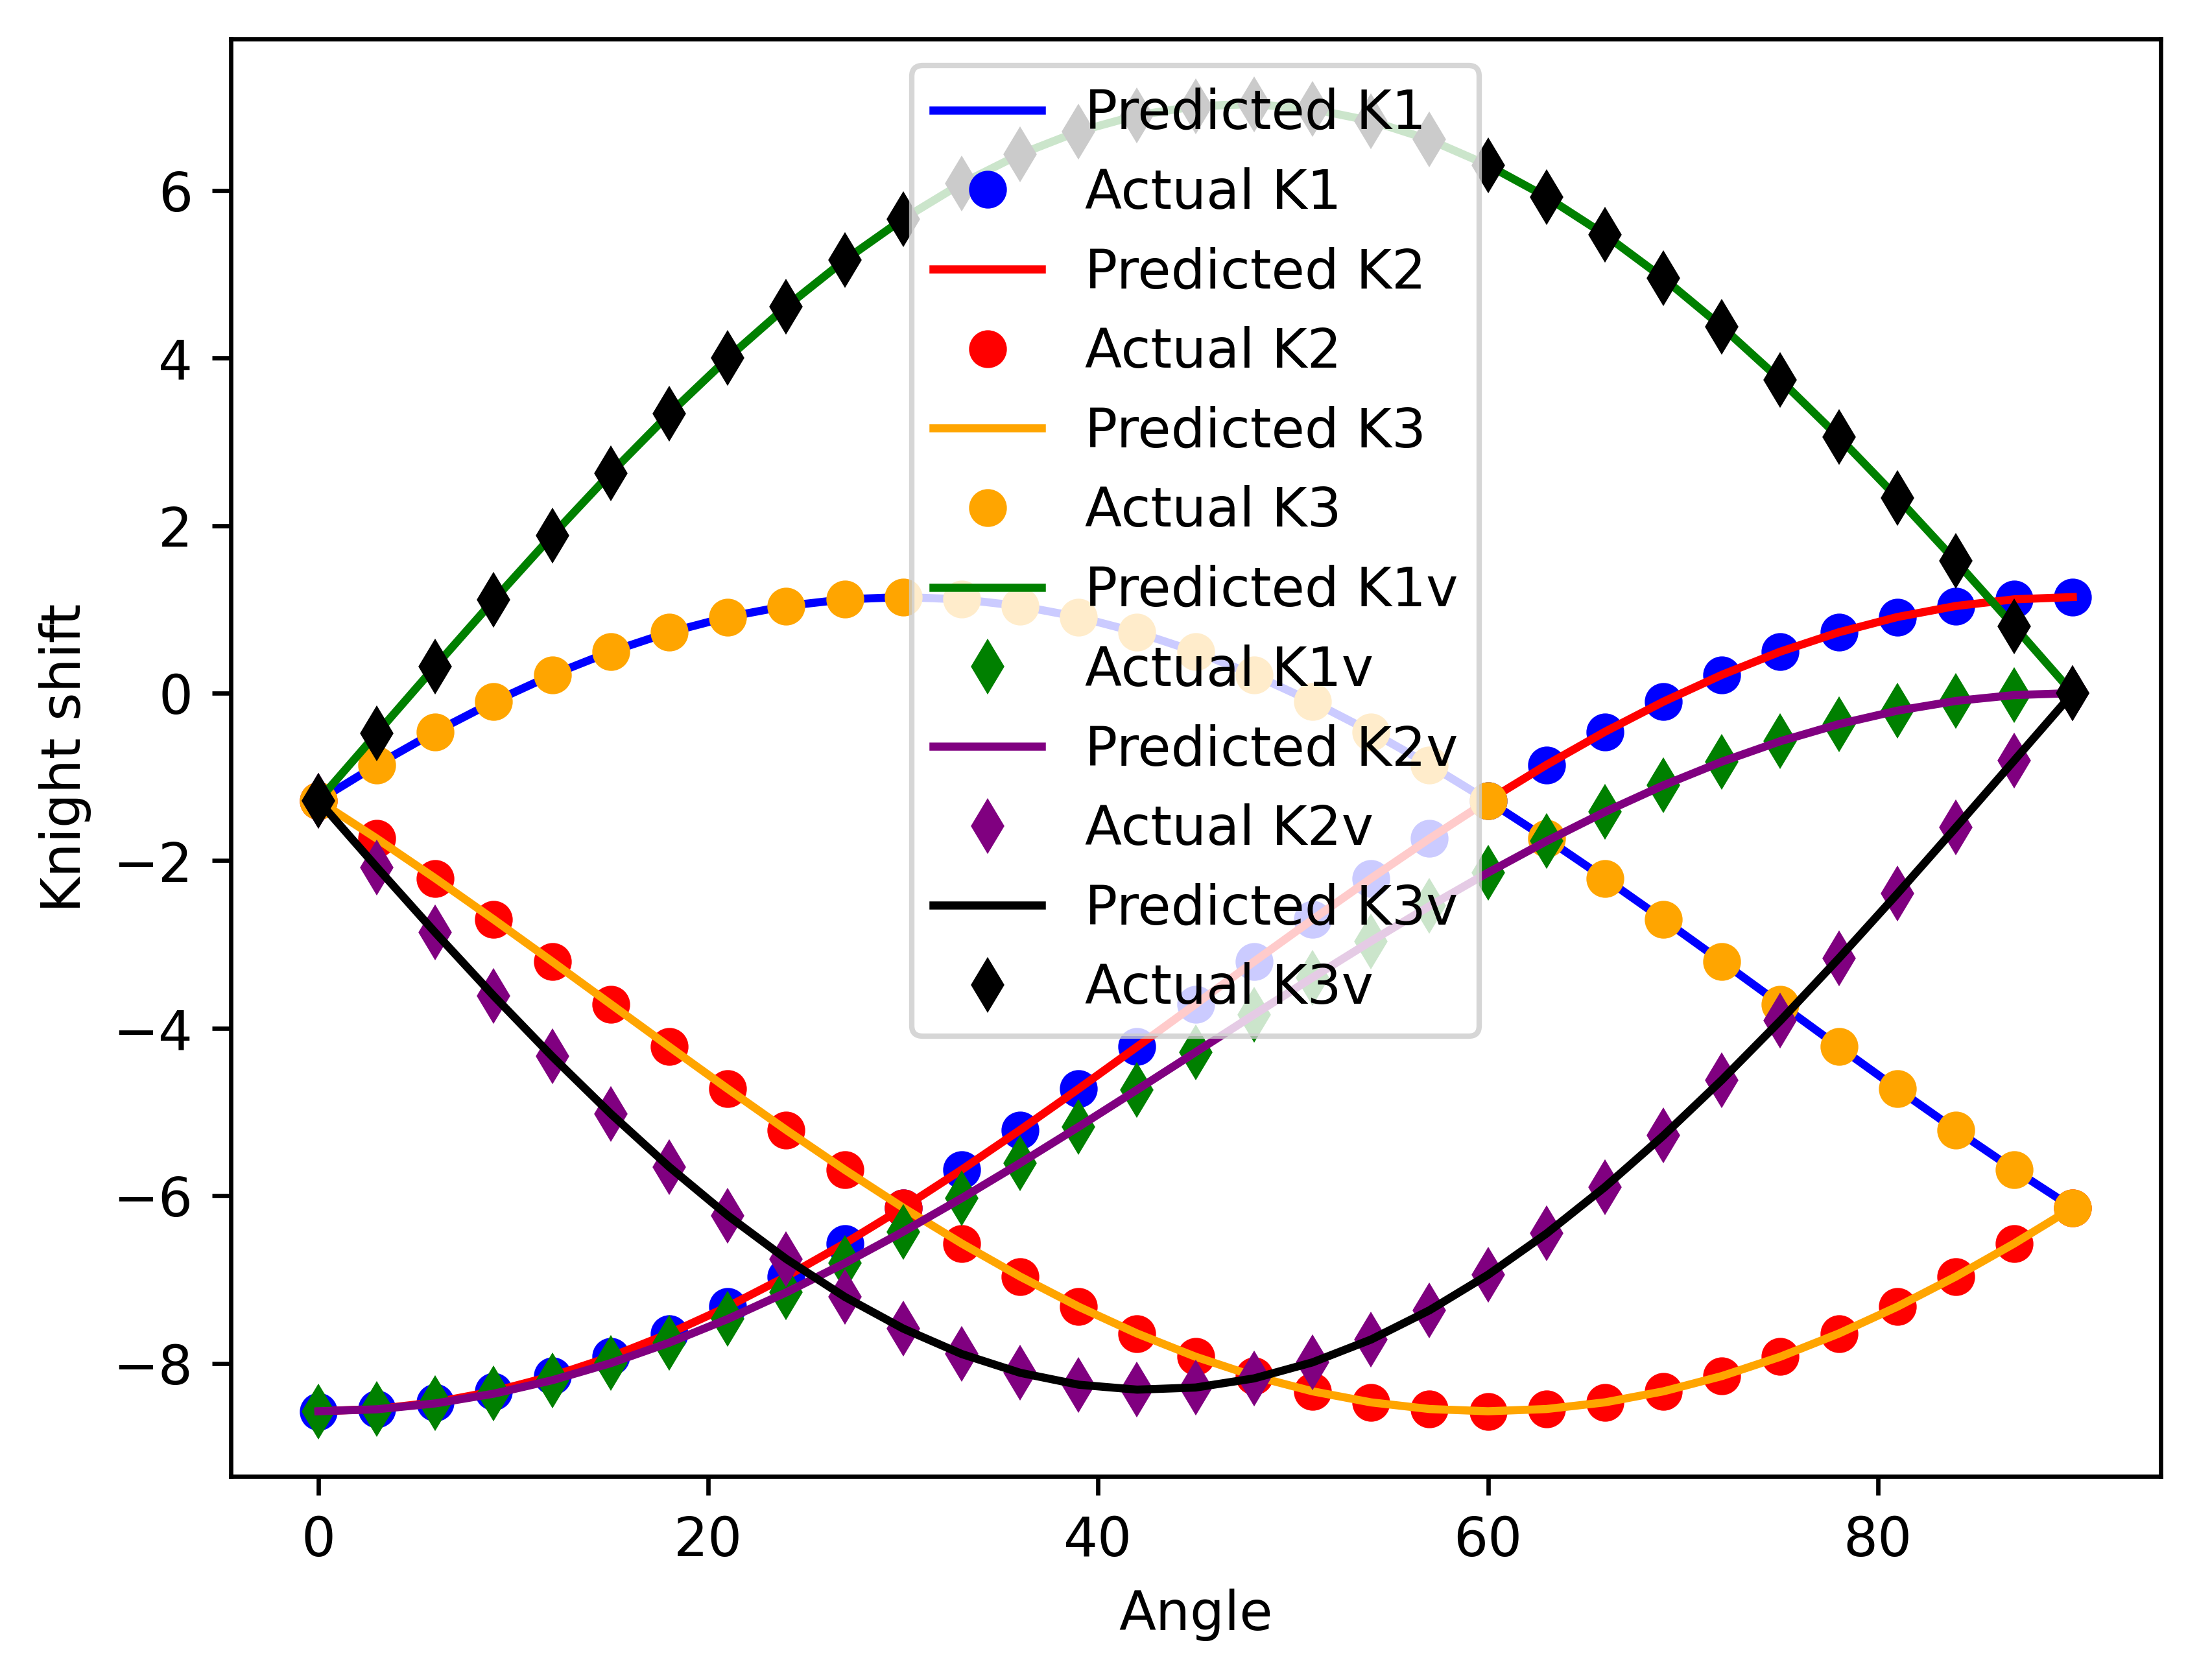

{'k1': -8.523792266845703, 'k2': 1.097792625427246, 'k3': -1.8107989774307498e-07, 'k4': -8.808075904846191, 'k5': 0.6218917369842529, 'k6': -0.6827405691146851, 't1': 5.5464264733018354e-05, 'p1': 90.0, 't2': 90.0, 'p2': 64.0386962890625}


In [9]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(global_best_params['k1'], dtype=torch.float32)
k2 = torch.tensor(global_best_params['k2'], dtype=torch.float32)
k3 = torch.tensor(global_best_params['k3'], dtype=torch.float32)
k4 = torch.tensor(global_best_params['k4'], dtype=torch.float32)
k5 = torch.tensor(global_best_params['k5'], dtype=torch.float32)
k6 = torch.tensor(global_best_params['k6'], dtype=torch.float32)
t1 = torch.tensor(global_best_params['t1'], dtype=torch.float32)
p1 = torch.tensor(global_best_params['p1'], dtype=torch.float32)
t2 = torch.tensor(global_best_params['t2'], dtype=torch.float32)
p2 = torch.tensor(global_best_params['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'o', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'o', label="Actual K3", color = "orange")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'd', label="Actual K1v", color = "green")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'd', label="Actual K2v", color = "purple")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'd', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

# 最適化後のパラメータを表示
print(global_best_params)